# Images of Road Traffic Signs

## Table of Contents
- [Data Set-Up](#dsu)
  - [Module Imports](#mi)
  - [Dataframe of Images](#doi)
  - [Training, Test and Validation Splitting](#ttavs)
- [Model for Type of Sign](#mftos)
  - [Image Processing - Type](#ipt)
  - [Learning Curve Function](#lcf)
  - [Base Model - Type](#bmt)
  - [First Fine-Tuned Model - Type](#fftmt)
  - [Final Fine-Tuned Model - Type](#finalftmt)
- [Model for Shape of Sign](#mfsos)
    - [Image Processing - Shape](#ips)
    - [Base Model - Shape](#bms)
    - [First Fine-Tuned Model - Shape](#fftms)
    - [Final Fine-Tuned Model - Shape](#finalftms)
- [Saving Appropriate Model](#sam)
- [Using Testing Set](#uts)
  - [Test Set Type](#tst)
  - [Test Set Shape](#tss)
- [Testing on Unseen Data](#toud)

## Data Set-Up <a id='dsu'></a>

#### Module Imports <a id='mi'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import keras
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import tensorflow as tf
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

#### Dataframe of Images <a id='doi'></a>

Lets initialise the dataframe, determining the shape and type of the images.

In [2]:
paths = ["./trafficsigns_dataset/diamond", "./trafficsigns_dataset/hex", 
"./trafficsigns_dataset/round", "./trafficsigns_dataset/square" , "./trafficsigns_dataset/triangle"]

imgs = []
types = []
shapes = []

for i in range(len(paths)):
    for root, dirs, files in os.walk(paths[i]):
        for name in files:
            if ".png" in name:
                imgs.append(os.path.join(root, name))
                types.append(str(os.path.join(root, name)).rsplit('/', 2)[-2])
                shapes.append(str(os.path.join(root, name)).rsplit('/', 3)[-3])
                
data = {"Image Paths" : imgs, "Types" : types, "Shapes" : shapes}

df = pd.DataFrame(data)

An quick overview of our clean data.

In [3]:
df

,Image Paths,Types,Shapes
0,./trafficsigns_dataset/diamond/rightofway/0003...,rightofway,diamond
1,./trafficsigns_dataset/diamond/rightofway/0180...,rightofway,diamond
2,./trafficsigns_dataset/diamond/rightofway/0170...,rightofway,diamond
3,./trafficsigns_dataset/diamond/rightofway/0011...,rightofway,diamond
4,./trafficsigns_dataset/diamond/rightofway/0123...,rightofway,diamond
...,...,...,...
3694,./trafficsigns_dataset/triangle/warning/01075_...,warning,triangle
3695,./trafficsigns_dataset/triangle/warning/00248_...,warning,triangle
3696,./trafficsigns_dataset/triangle/warning/00138_...,warning,triangle
3697,./trafficsigns_dataset/triangle/warning/00025_...,warning,triangle


#### Training, Test and Validation Splitting <a id='ttavs'></a>

Let us now split the data into training, test, validation sets.

In [4]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


## Model for Type of Sign <a id='mftos'></a>

### Image Processing - Type <a id='ipt'></a>

Create data generator for each split set.

In [5]:
train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image Paths",
        y_col="Types",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image Paths",
        y_col="Types",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


Lets double check labels are correct for a sample of images.

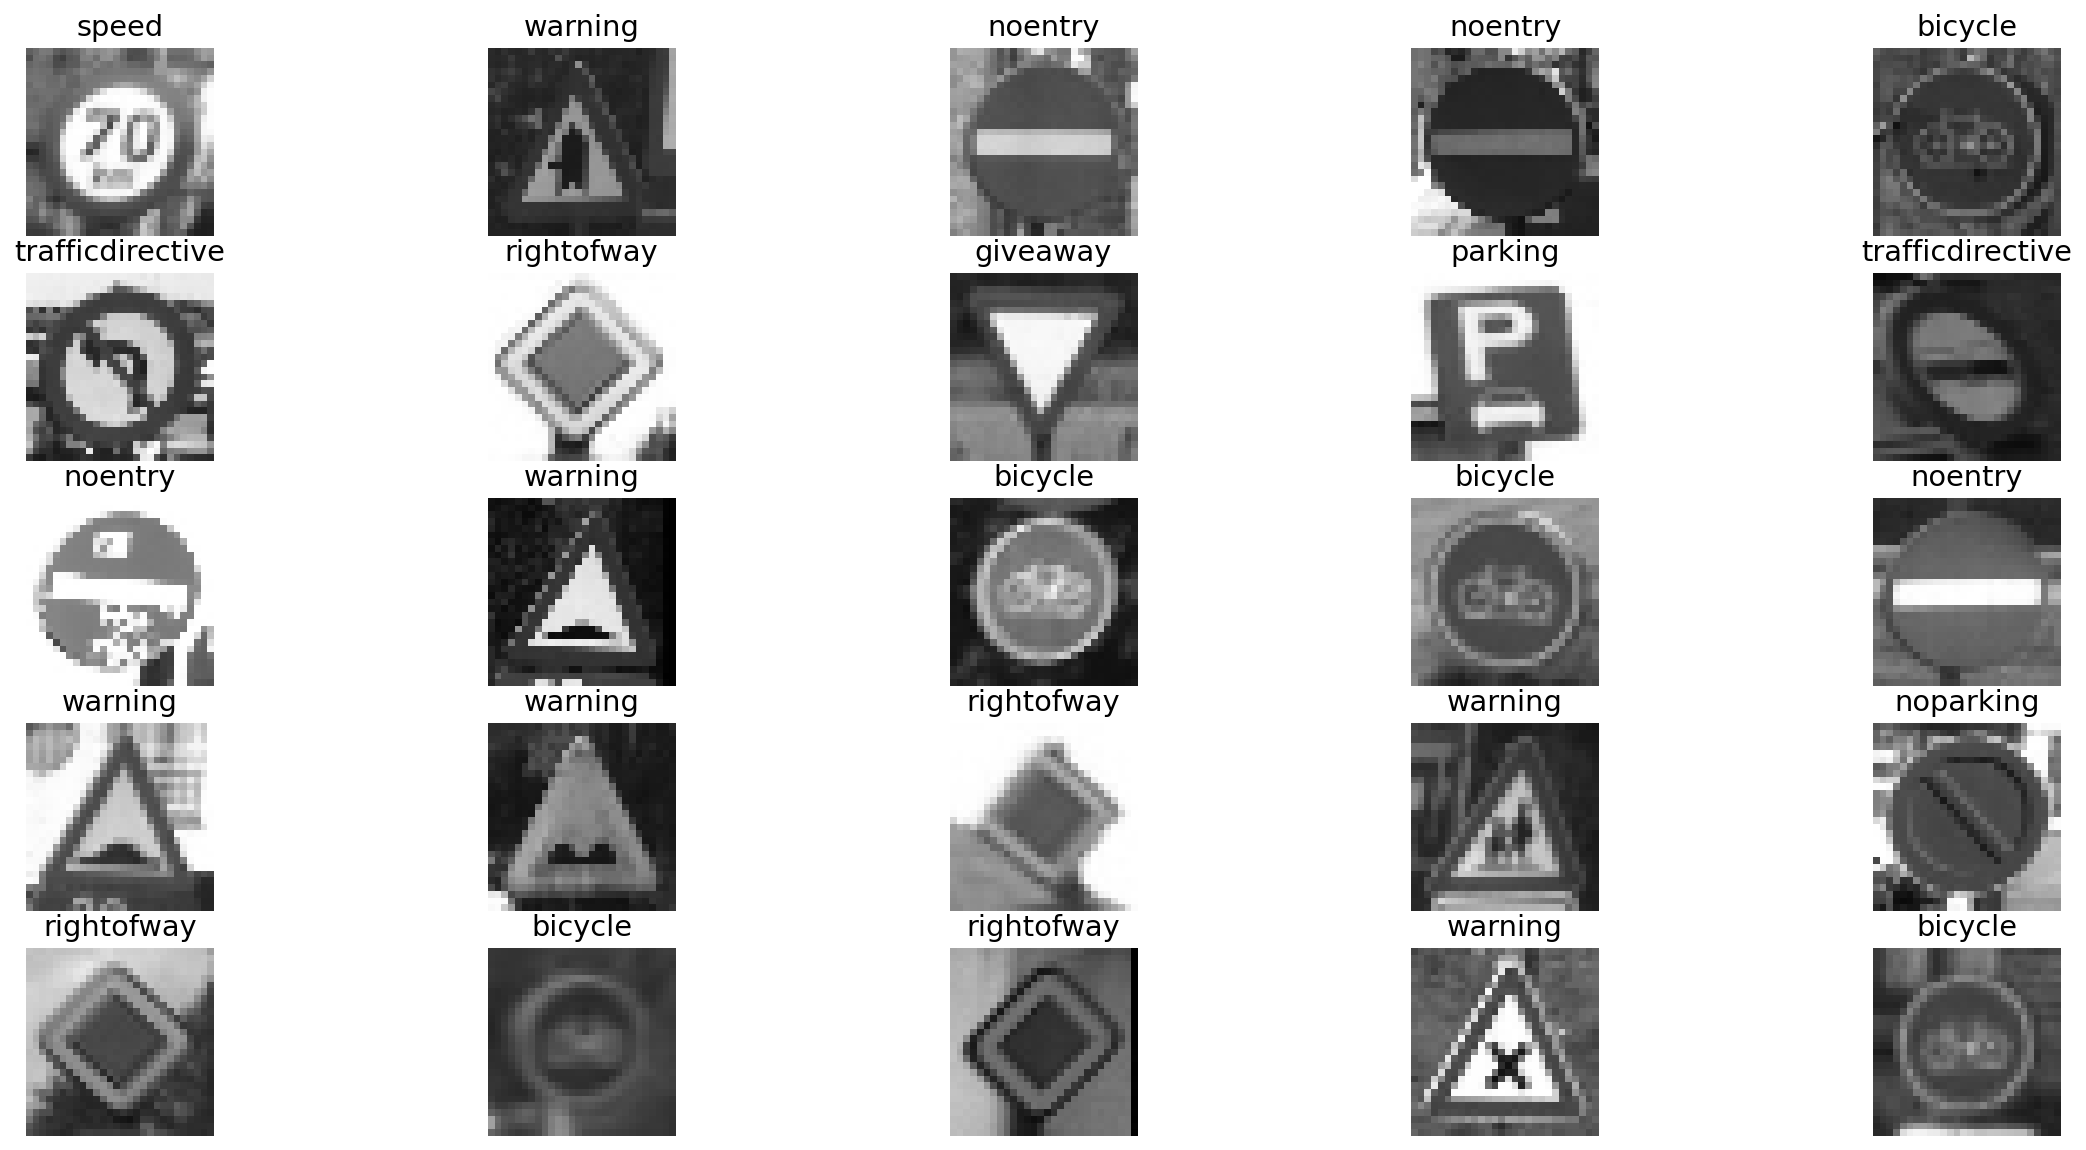

In [6]:
type_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic','noentry','noparking',
              'roundabout','speed','trafficdirective','traveldirection', 'continue',
              'crossing', 'laneend', 'parking', 'giveaway', 'warning']
type_names.sort()

plt.figure(figsize=(20,10))
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)

    # generate batch of images
    batch = train_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # reshape array to proper size
    image = np.squeeze(image)
    
    # labels for images
    label = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title(type_names[np.argmax(label[0])])
    plt.axis('off')
plt.show()

### Learning Curve Function <a id='lcf'></a>

This learning curve function will help us plot our models. It will also help us diagnose performance and issues with our model.

In [7]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, expected, metric_name='Accuracy'):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', expected], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', expected], loc='upper left')

    plt.show()

### Base Model - Type <a id='bmt'></a>

Lets begin by creating our base-line model. We will use a VGG template which consists of different blocks. Each block contains convolution, activation and pooling. Since, we already have small gray-scaled images we will only use two blocks.

VGG will have 3x3 convolution kernels. The pooling is always max-pooling which will be 2x2. Padding will ensure no pixels are lost during the convolution step. The activation function will be ReLU.

In [8]:
model_Type_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16),
])

Compile and fit the model.

In [9]:
model_Type_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [10]:
history_Type_VGG_1 = model_Type_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=20, verbose=0)

The resulting performance plots. (Explained further in report)

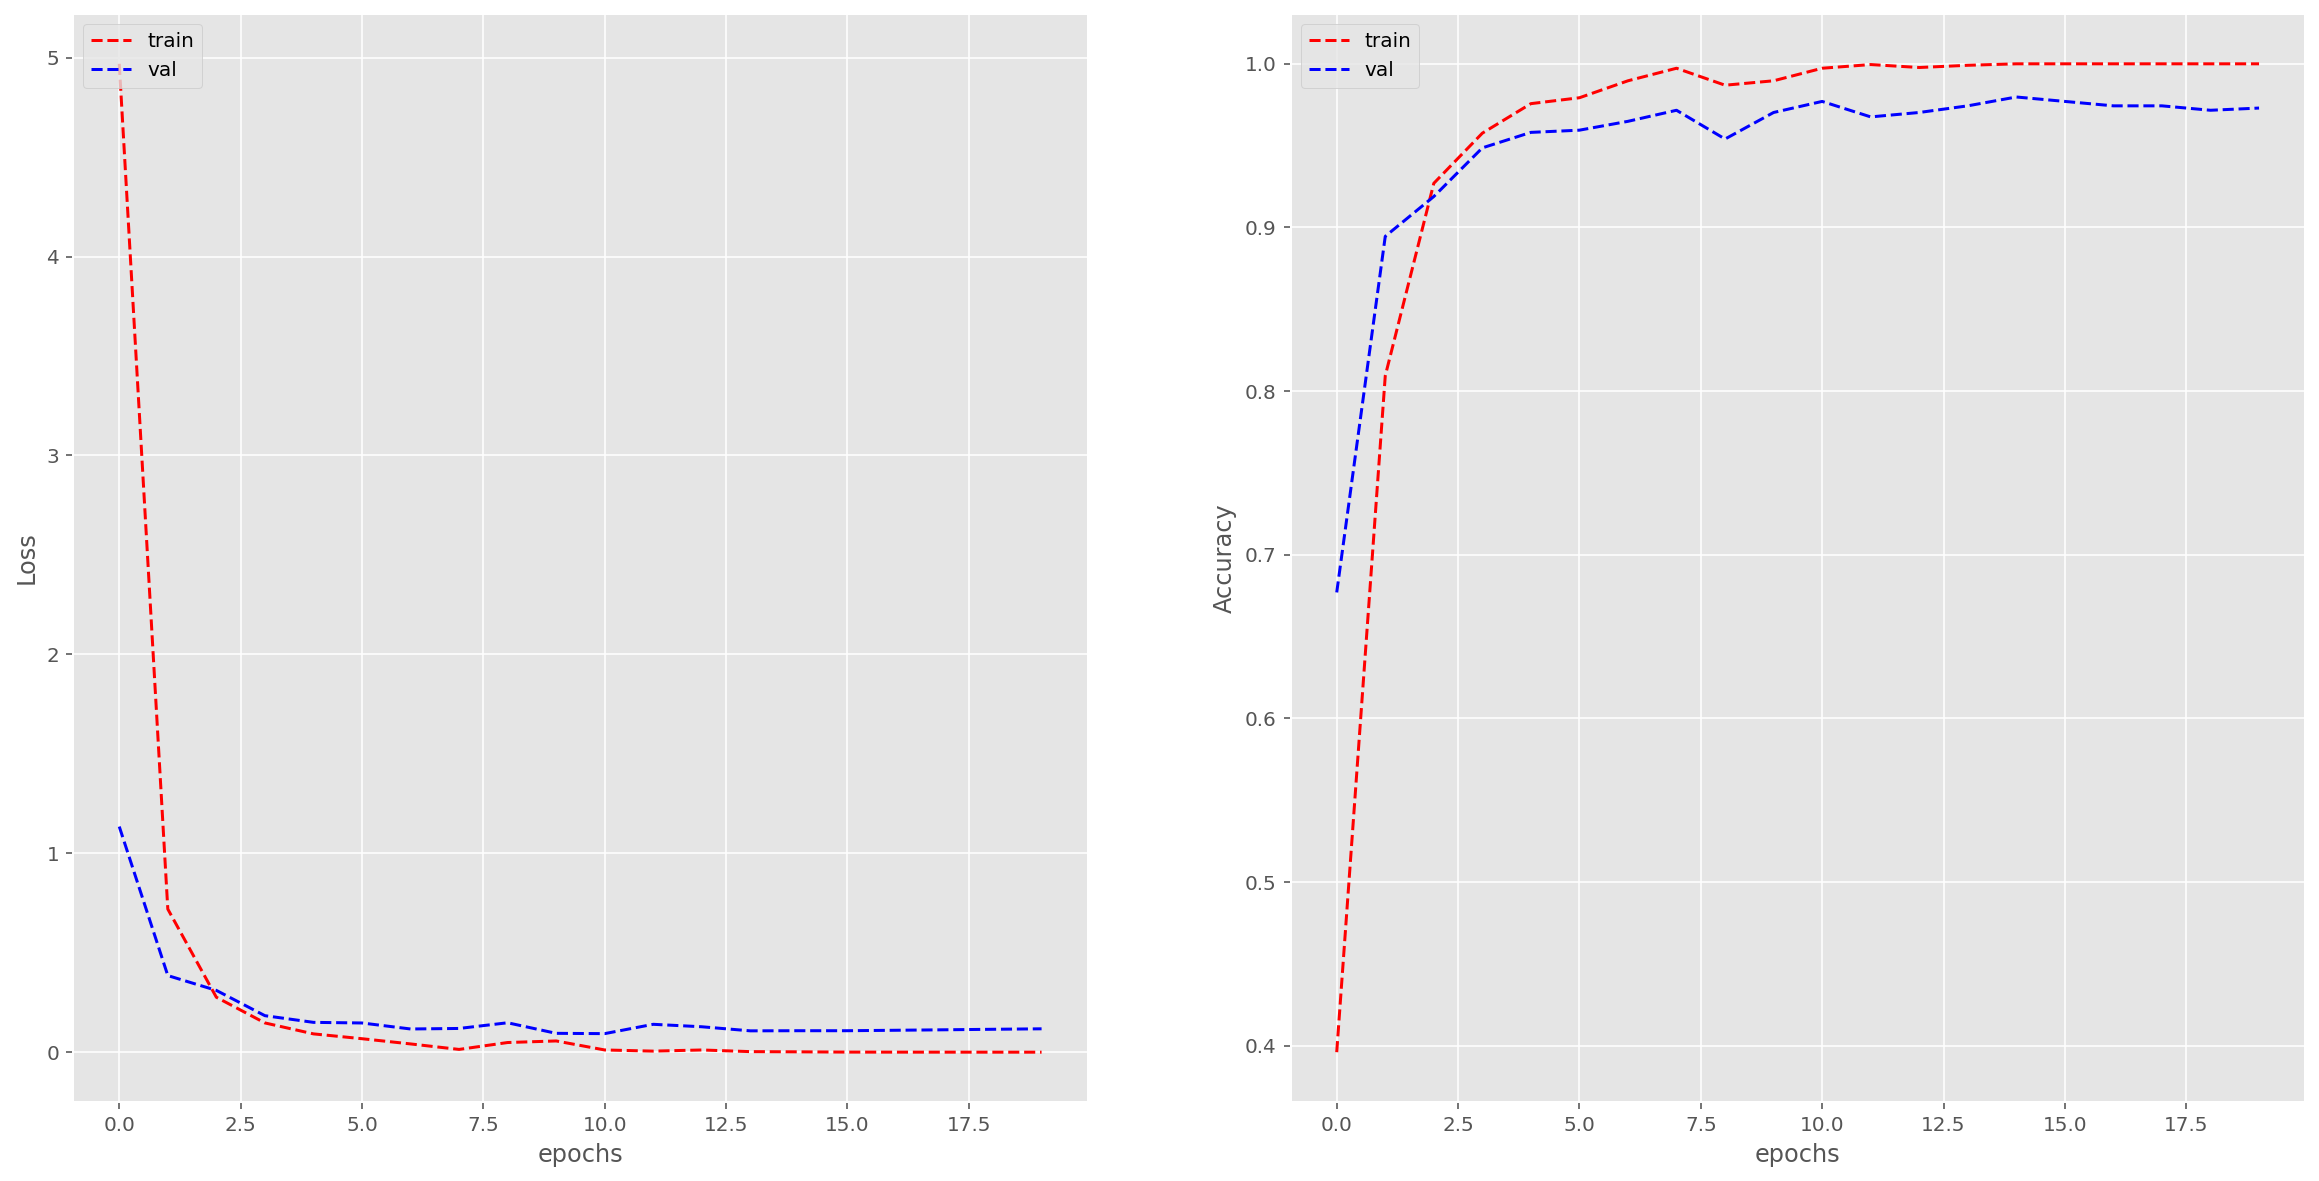

In [11]:
plot_learning_curve(history_Type_VGG_1.history['loss'], history_Type_VGG_1.history['val_loss'], 
                    history_Type_VGG_1.history['categorical_accuracy'], history_Type_VGG_1.history['val_categorical_accuracy'], 
                    'val', metric_name='Accuracy')

### First Fine-Tuned Model - Type <a id='fftmt'></a>

Fit the fine tuned model (Decrease training iterations).

In [12]:
history_Type_VGG_2 = model_Type_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)

The resulting performance plots. (Explained further in report)

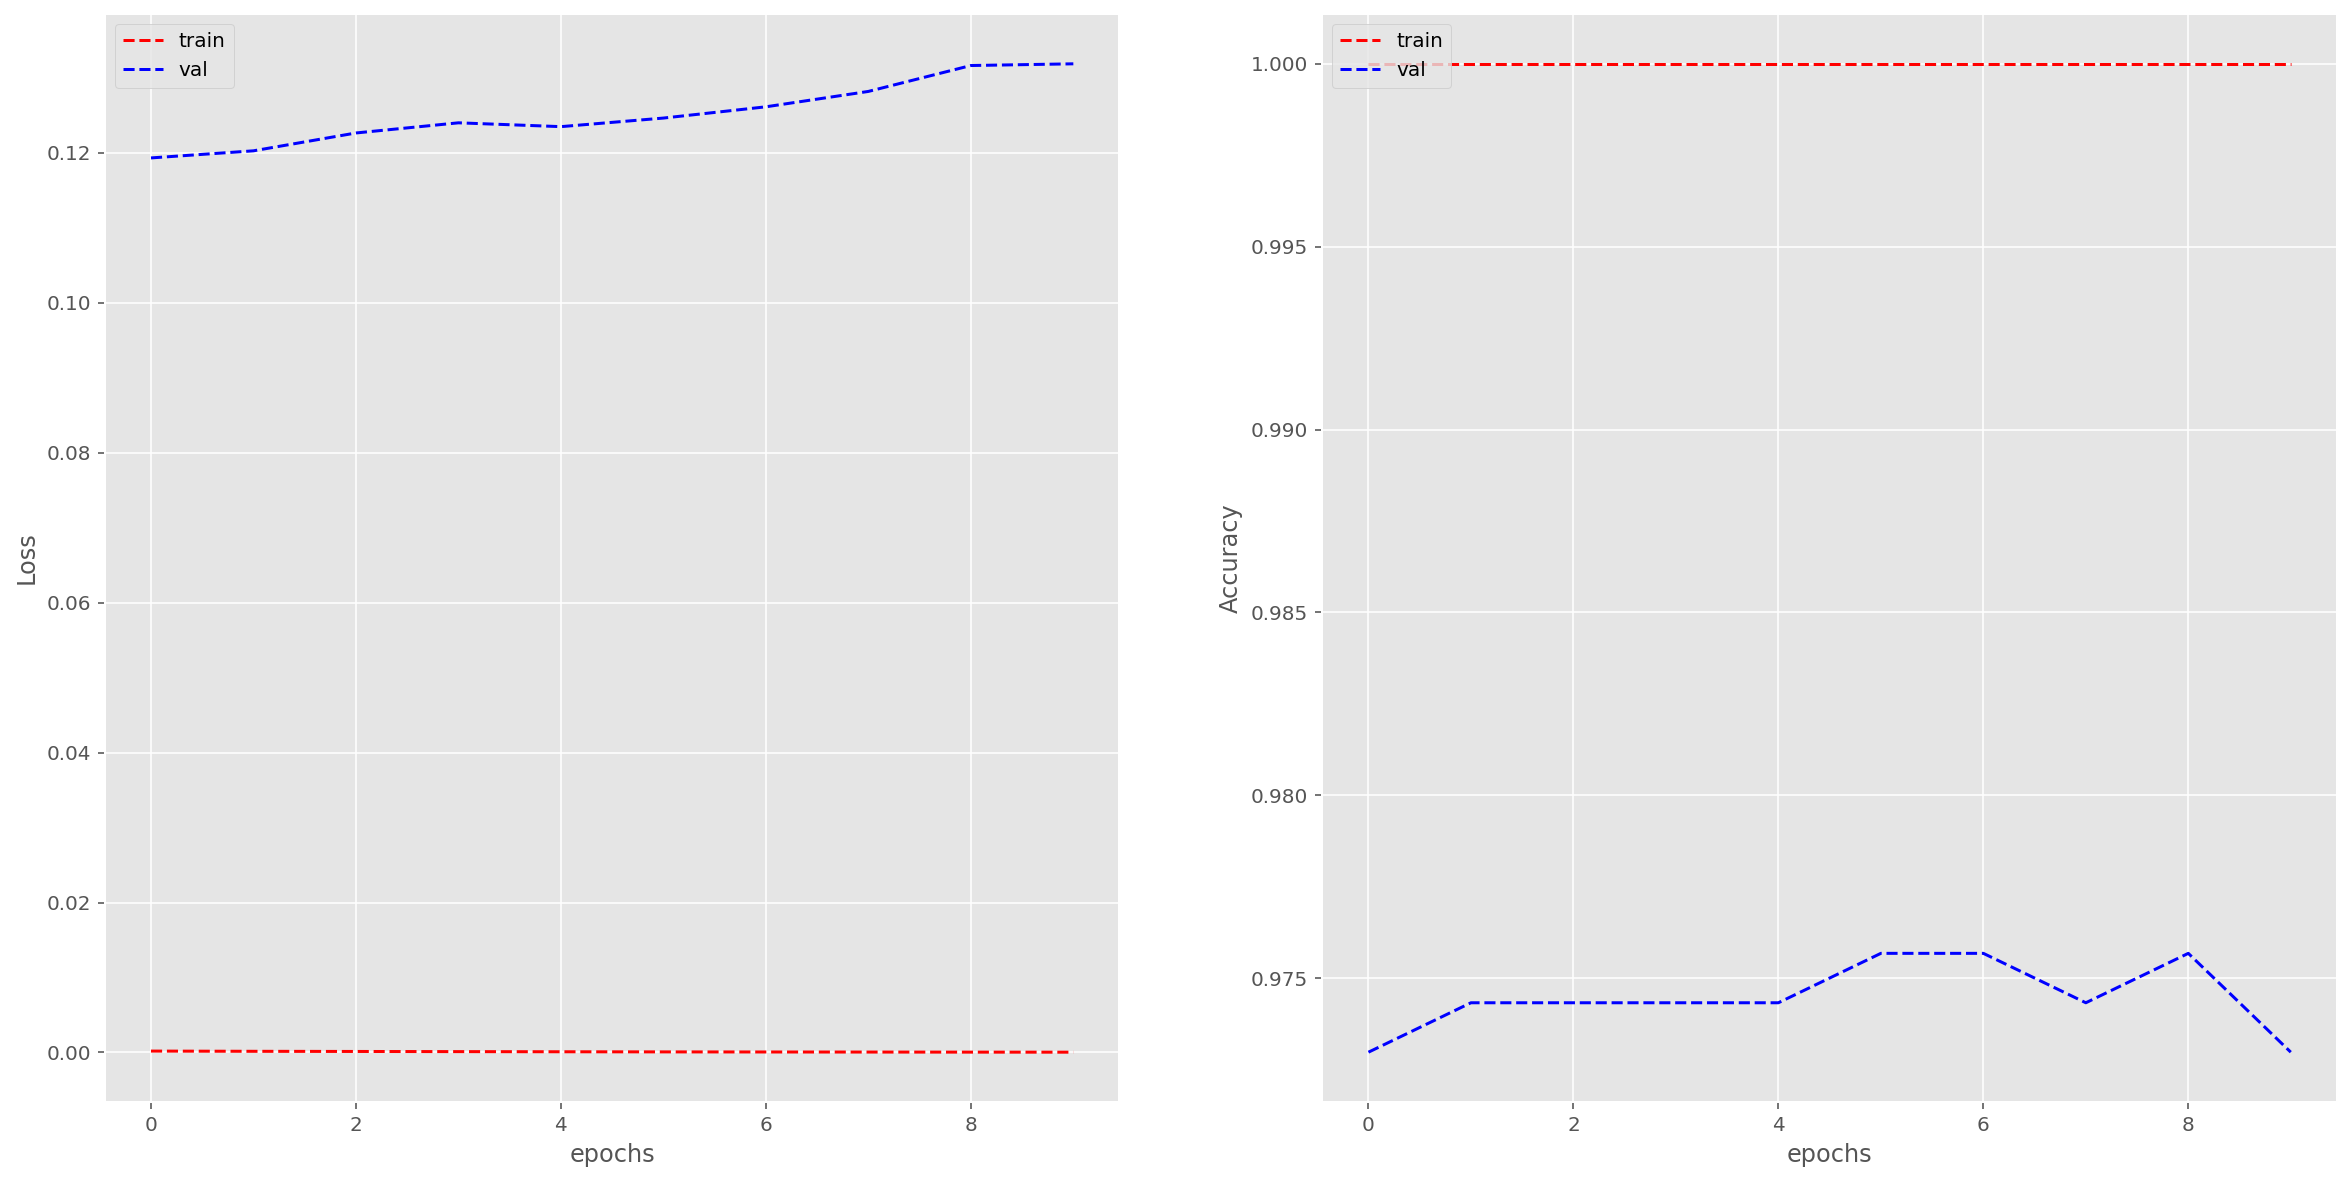

In [13]:
plot_learning_curve(history_Type_VGG_2.history['loss'], history_Type_VGG_2.history['val_loss'], 
                    history_Type_VGG_2.history['categorical_accuracy'], history_Type_VGG_2.history['val_categorical_accuracy'], 
                    'val', metric_name='Accuracy')

### Final Fine-Tuned Model - Type <a id='finalftmt'></a>

For the final fine-tuned model implement L2 and dropout regularization.

In [14]:
reg_lambda = 0.001

model_Type_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(16),
])

Compile and fit the fine tuned model.

In [15]:
model_Type_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [16]:
history_Type_VGG_3 = model_Type_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)

The resulting performance plots. (Explained further in report)

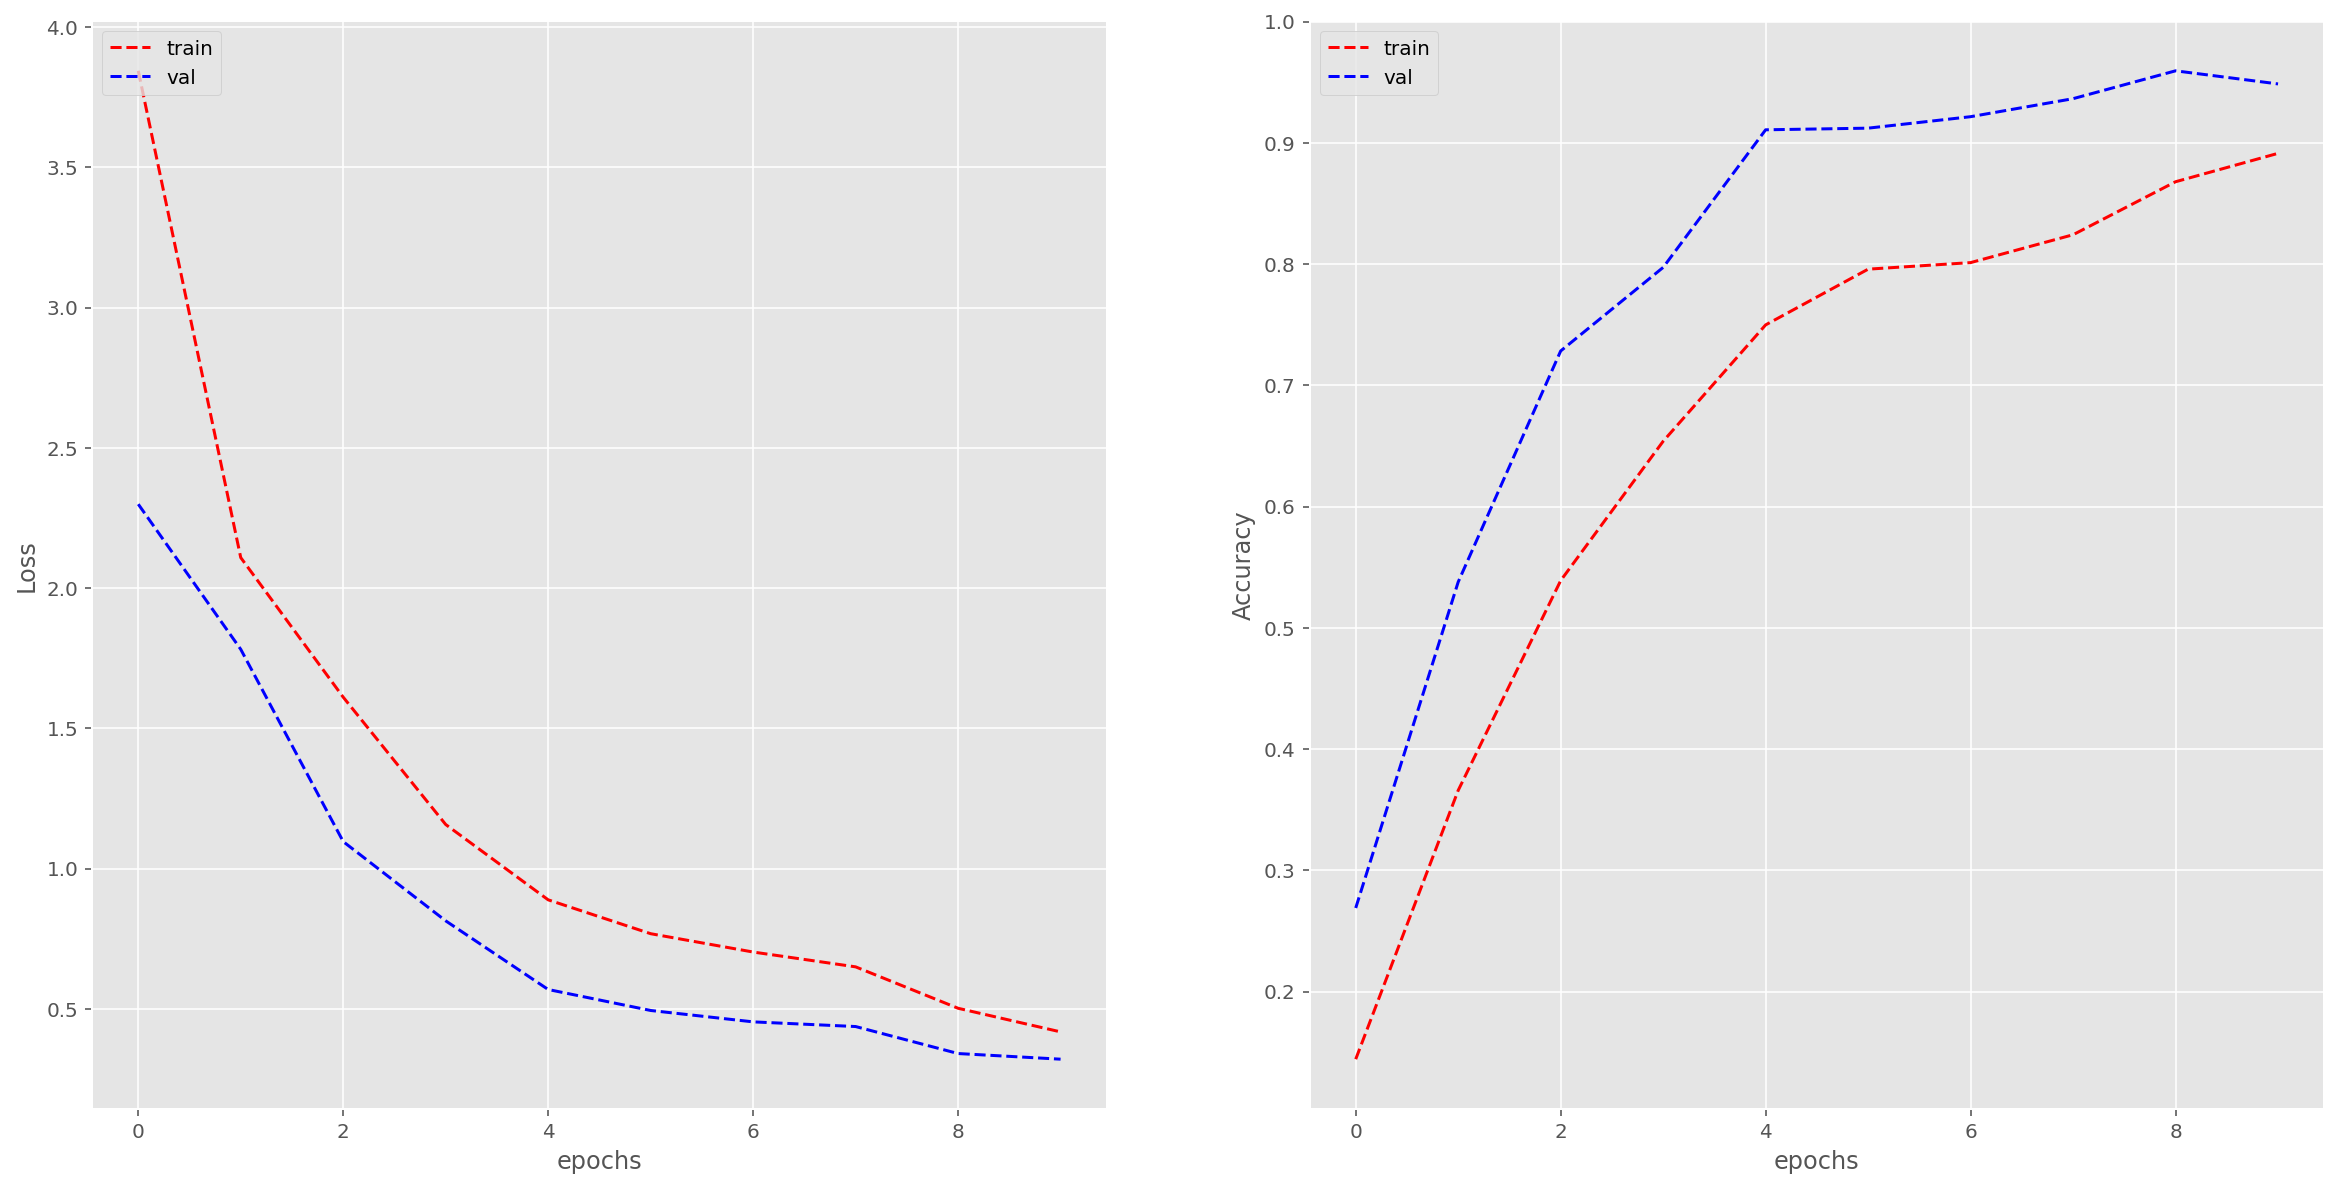

In [17]:
plot_learning_curve(history_Type_VGG_3.history['loss'], history_Type_VGG_3.history['val_loss'], 
                    history_Type_VGG_3.history['categorical_accuracy'], history_Type_VGG_3.history['val_categorical_accuracy'], 
                    'val', metric_name='Accuracy')

## Model for Shape of Sign <a id='mfsos'></a>

### Image Processing - Shape <a id='ips'></a>

Create data generator for each split set. This time for the shapes of signs.

In [18]:
train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image Paths",
        y_col="Shapes",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image Paths",
        y_col="Shapes",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


Lets double check labels are correct for a sample of images.

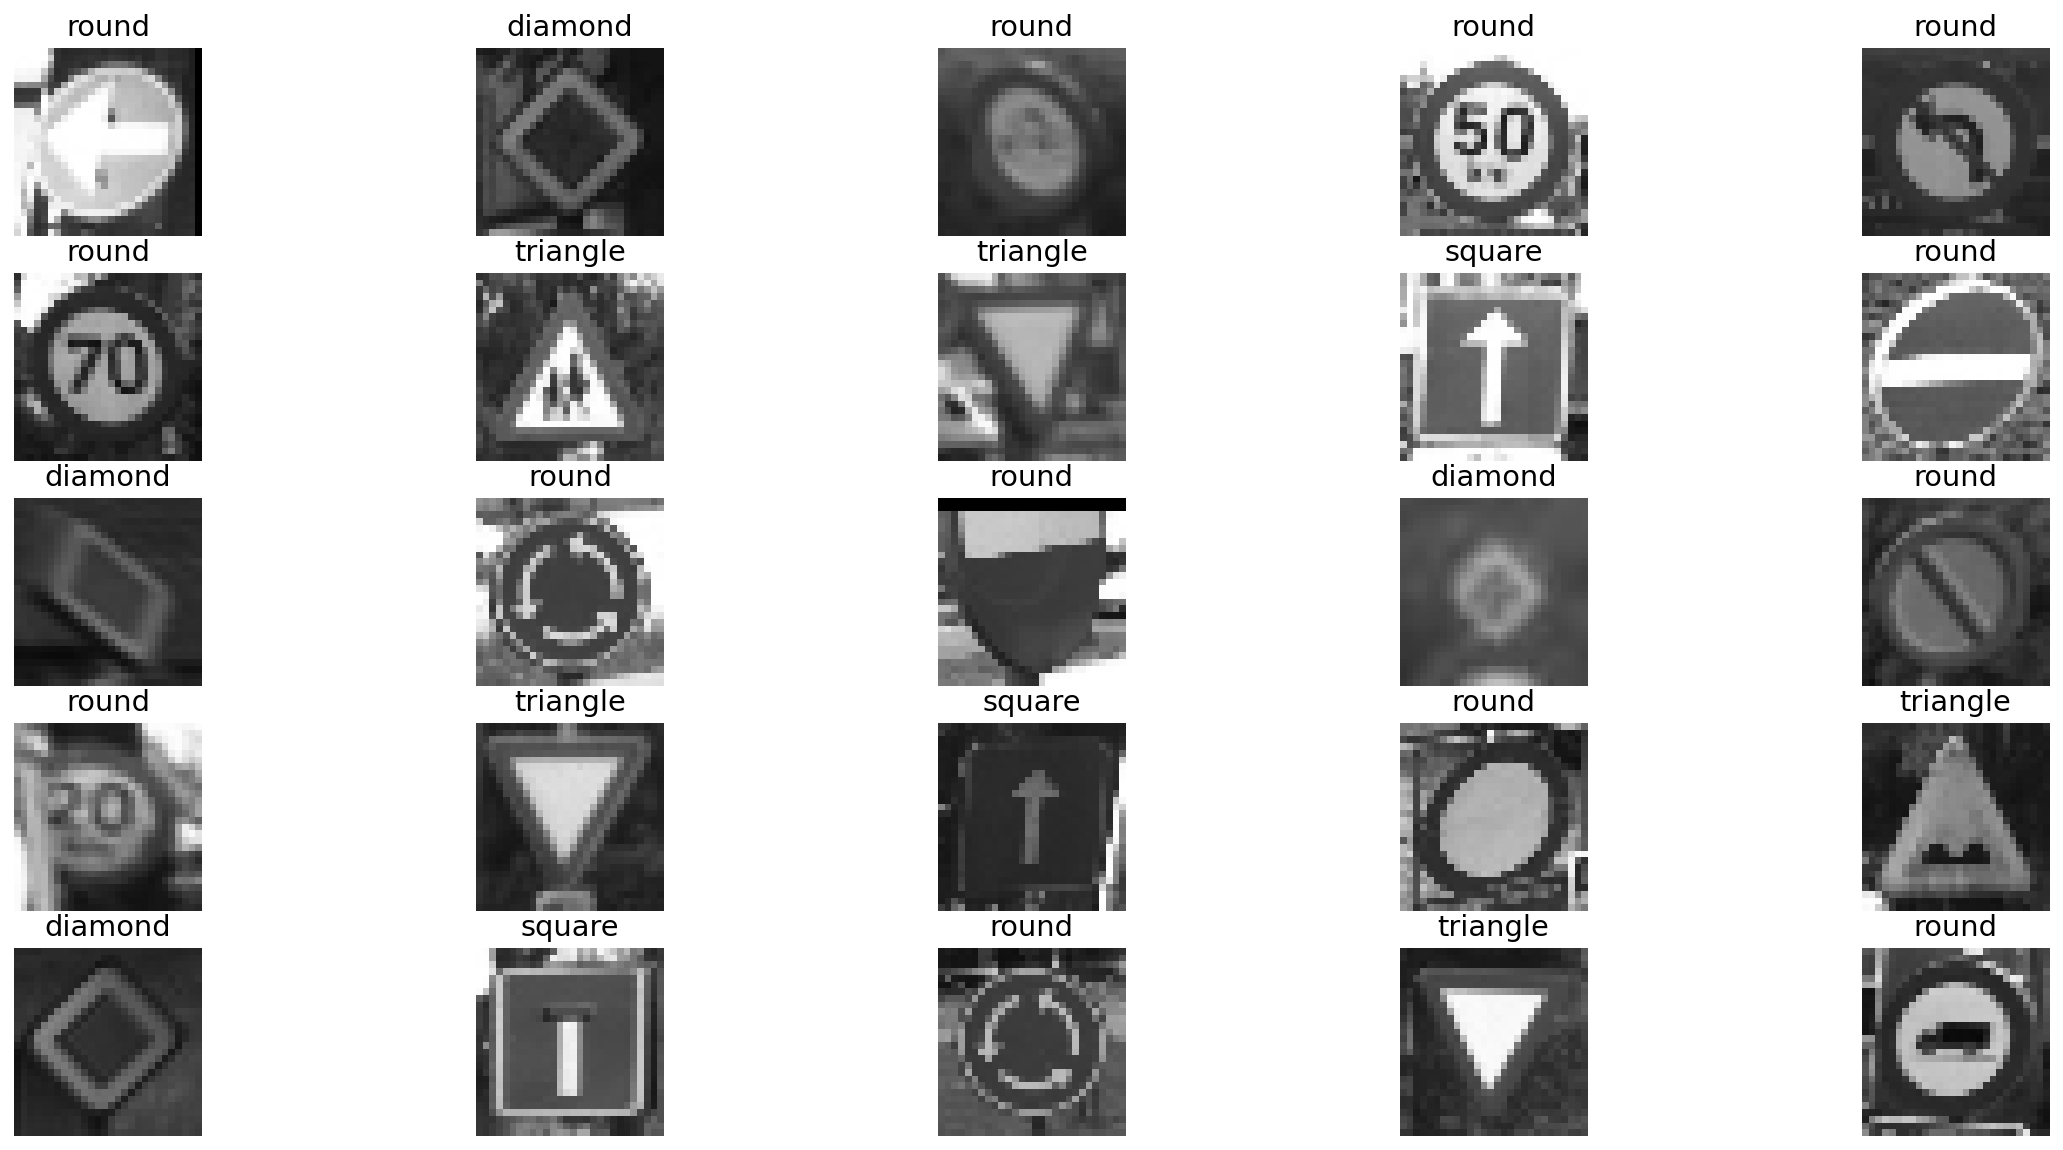

In [19]:
shape_names = ['diamond','hex','round','square','triangle']
shape_names.sort()

plt.figure(figsize=(20,10))
for i in range(25):
    # define subplot
    plt.subplot(5, 5, i+1)

    # generate batch of images
    batch = train_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # reshape array to proper size
    image = np.squeeze(image)
    
    # labels for images
    label = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title(shape_names[np.argmax(label[0])])
    plt.axis('off')
plt.show()

### Base Model - Shape <a id='bms'></a>

The base-line model remains the same as the model for the type of sign classification.

In [20]:
model_Shape_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5),
])

Compile and fit the model.

In [21]:
model_Shape_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [22]:
history_Shape_VGG_1 = model_Shape_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=20, verbose=0)

The resulting performance plots. (Explained further in report)

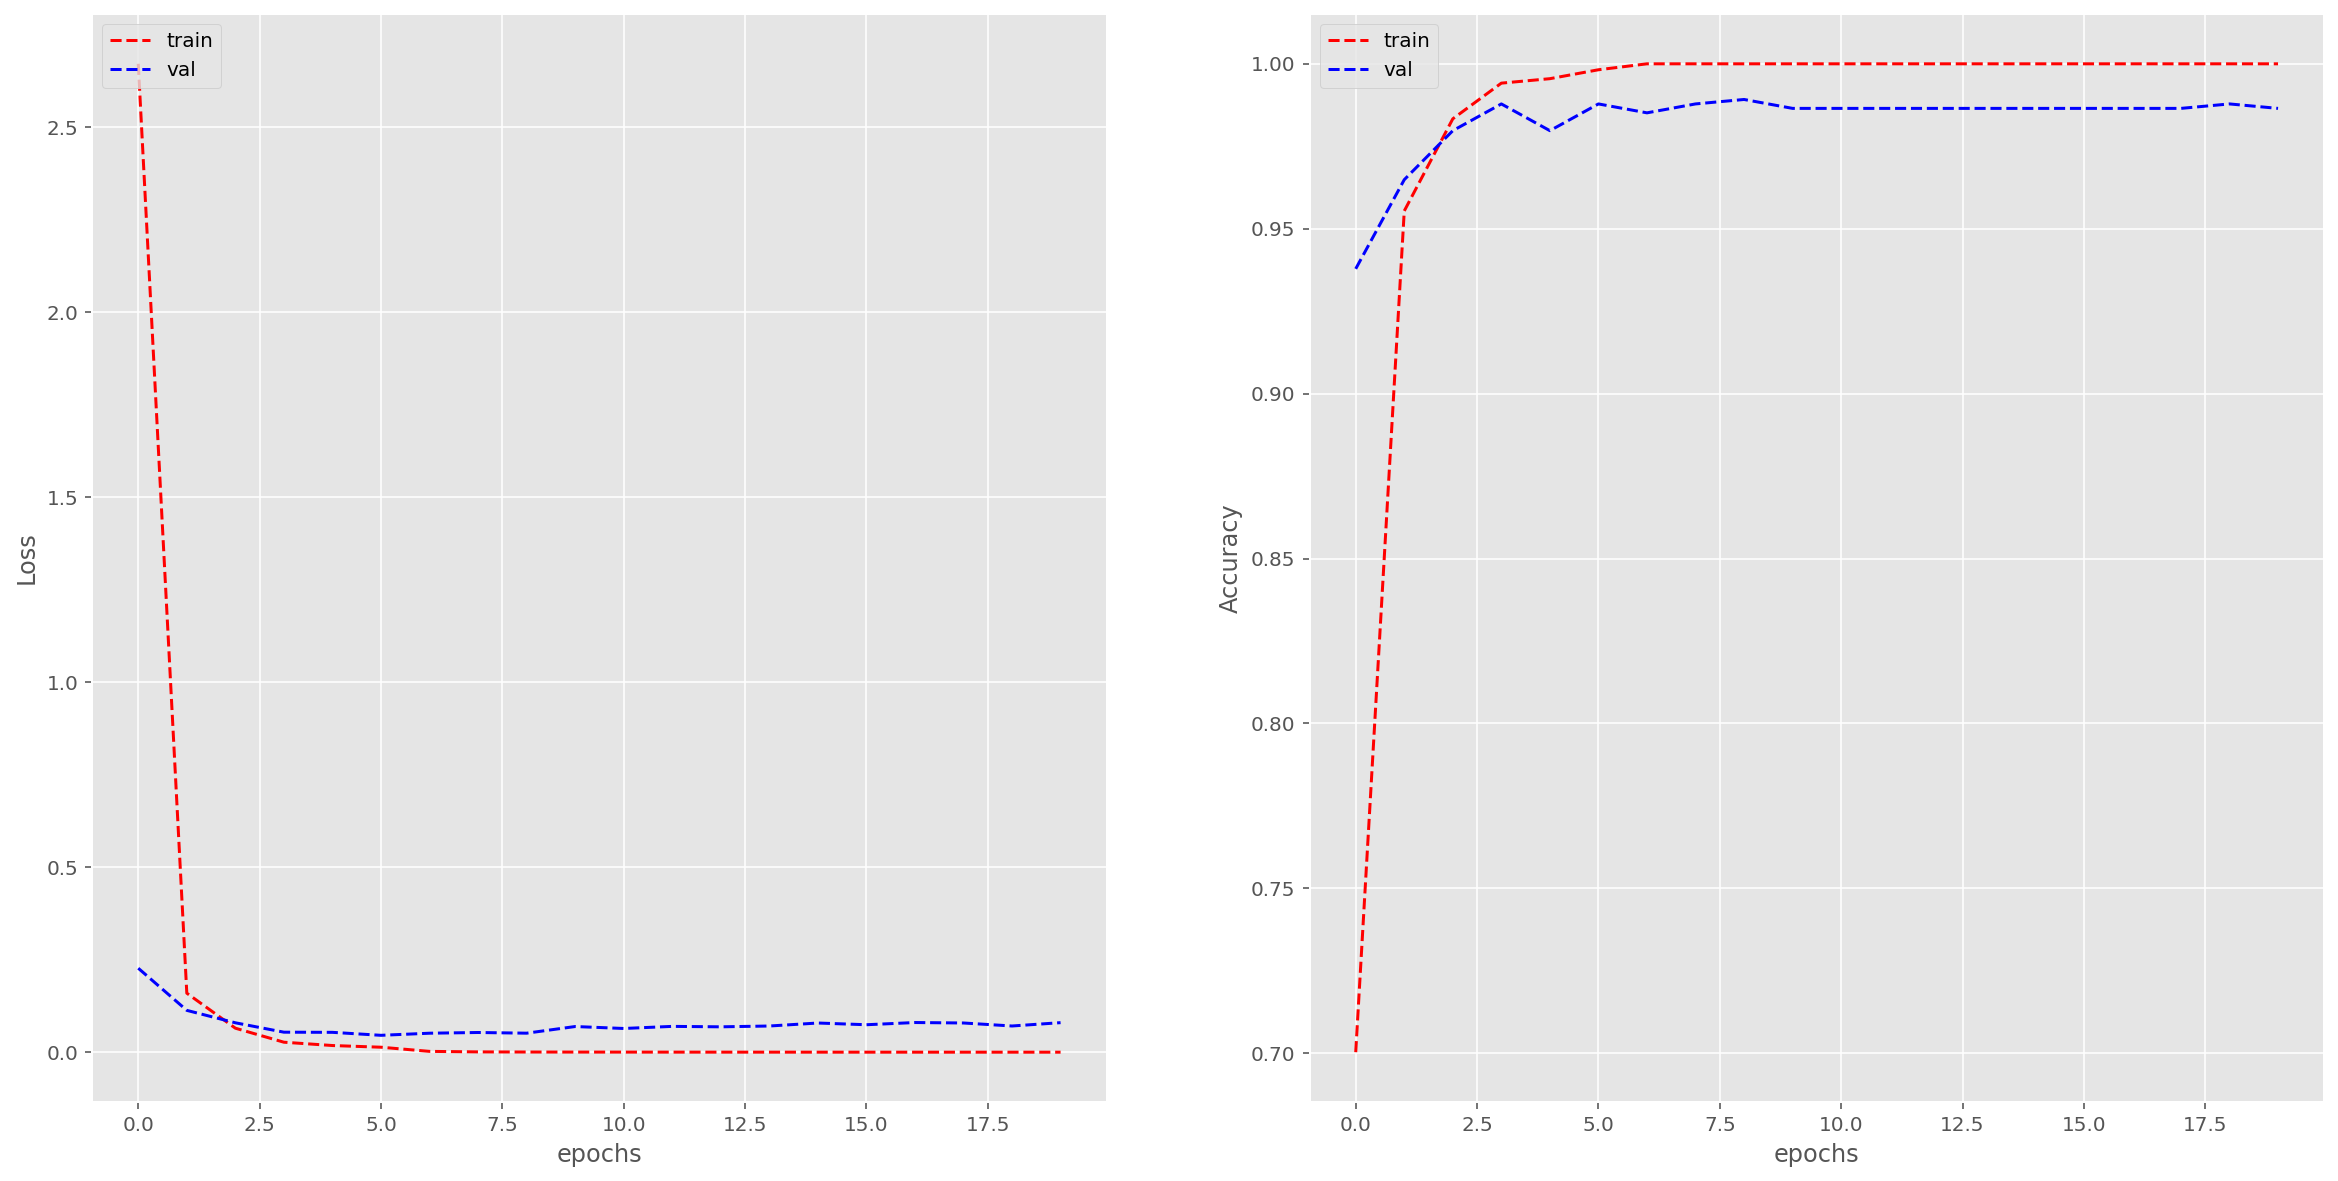

In [23]:
plot_learning_curve(history_Shape_VGG_1.history['loss'], history_Shape_VGG_1.history['val_loss'], 
                    history_Shape_VGG_1.history['categorical_accuracy'], history_Shape_VGG_1.history['val_categorical_accuracy'], 
                    'val', metric_name='Accuracy')

### First Fine-Tuned Model - Shape <a id='fftms'></a>

Fit the fine tuned model (Decrease training iterations).

In [24]:
history_Shape_VGG_2 = model_Shape_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)

The resulting performance plots. (Explained further in report)

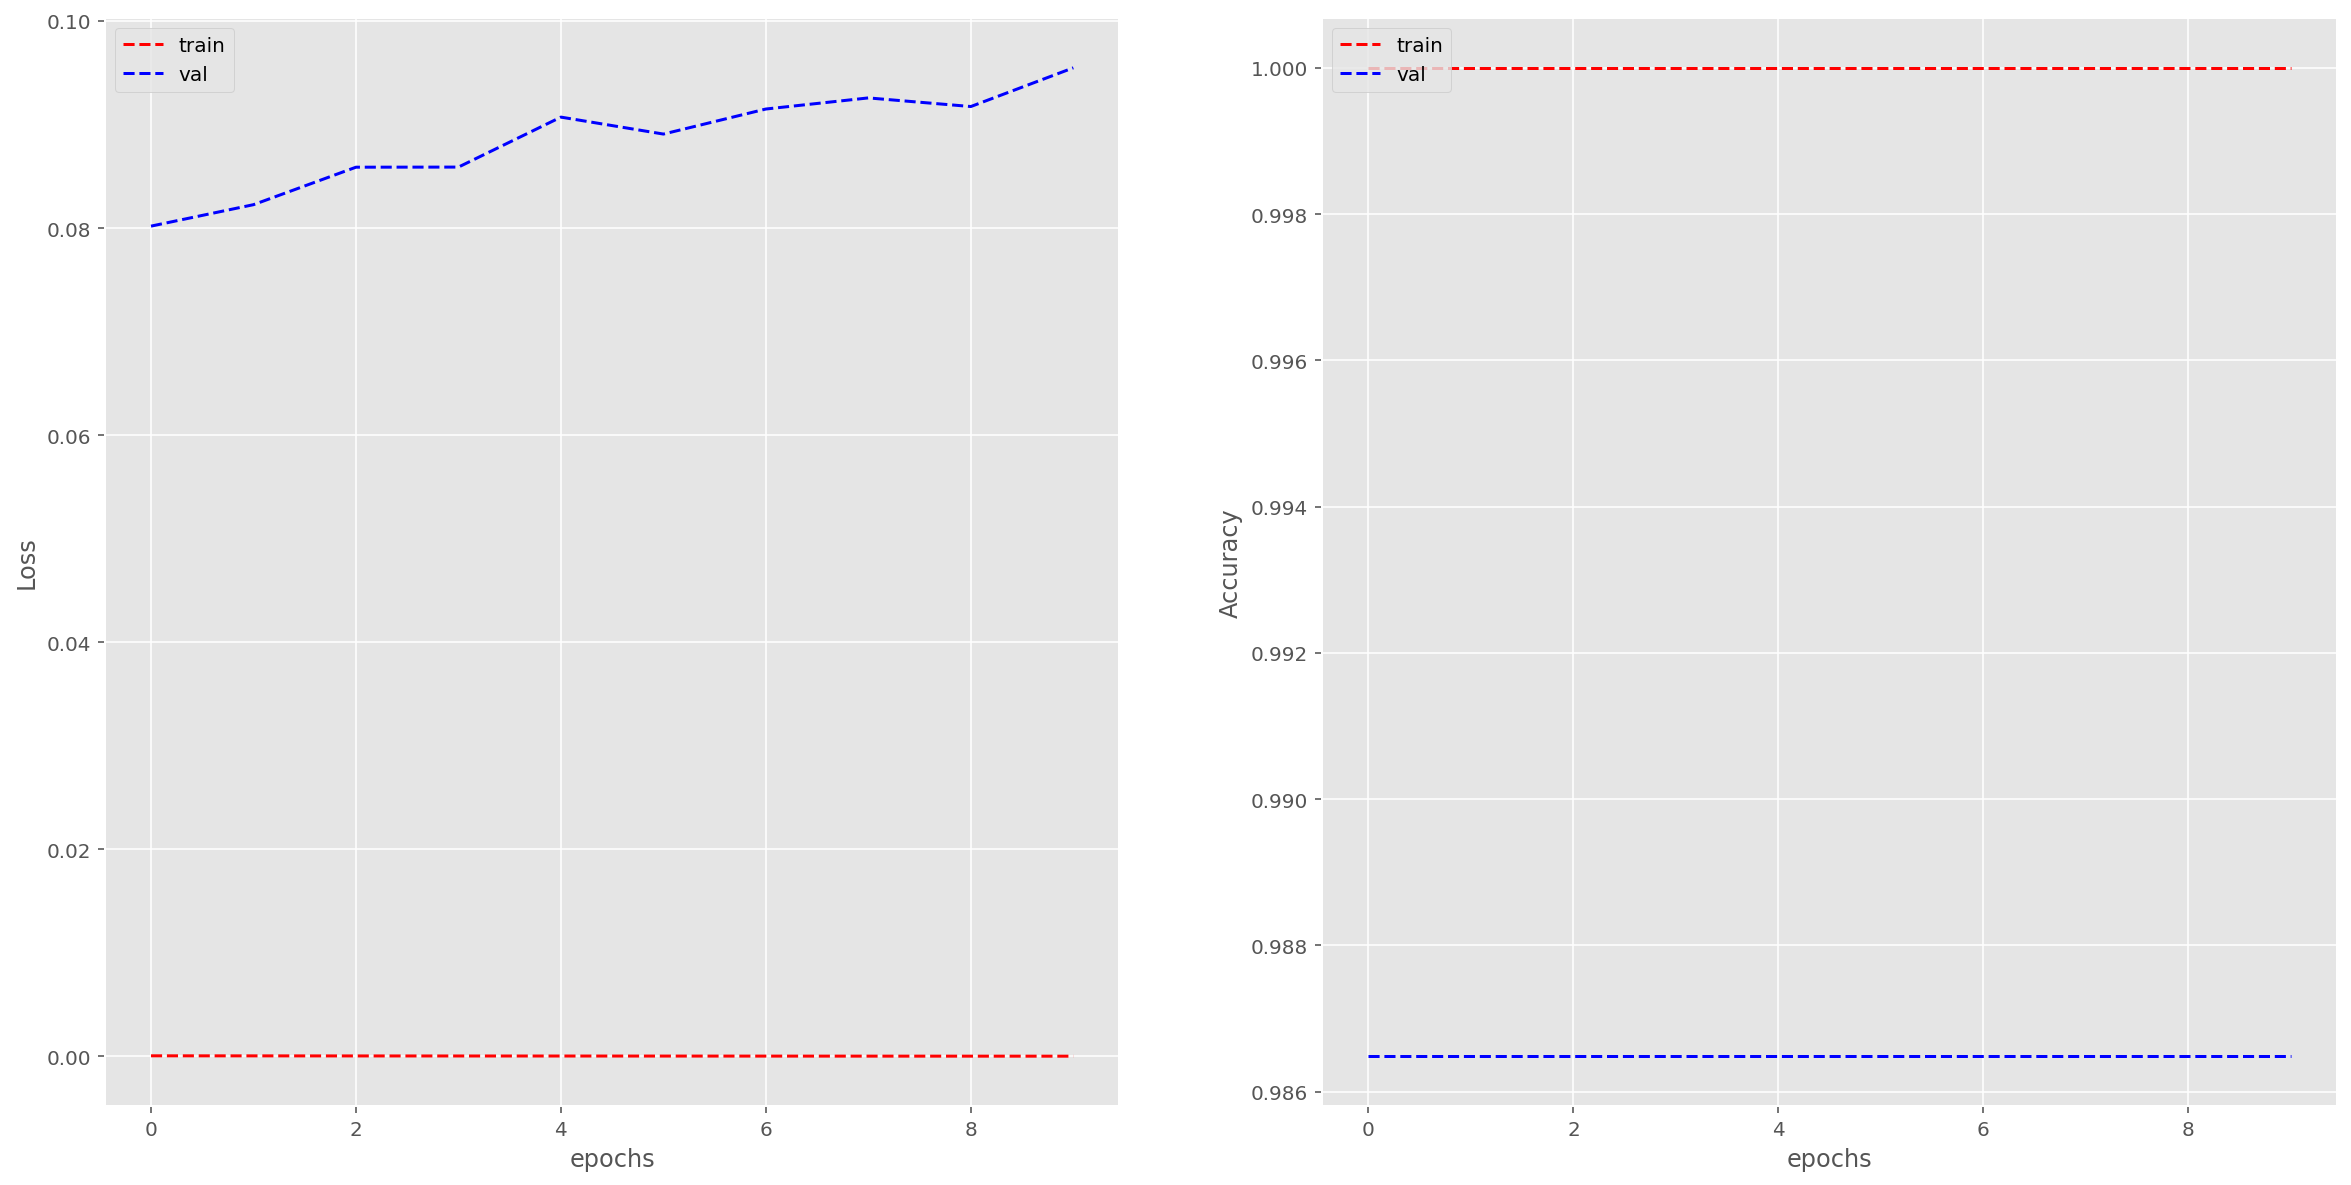

In [25]:
plot_learning_curve(history_Shape_VGG_2.history['loss'], history_Shape_VGG_2.history['val_loss'], 
                    history_Shape_VGG_2.history['categorical_accuracy'], history_Shape_VGG_2.history['val_categorical_accuracy'], 
                    'val', metric_name='Accuracy')

### Final Fine-Tuned Model - Shape <a id='finalftms'></a>

For the final fine-tuned model implement L2 and dropout regularization.

In [26]:
reg_lambda = 0.001

model_Shape_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(5),
])

Compile and fit the fine tuned model.

In [27]:
model_Shape_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [28]:
history_Shape_VGG_3 = model_Shape_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=10, verbose=0)

The resulting performance plots. (Explained further in report)

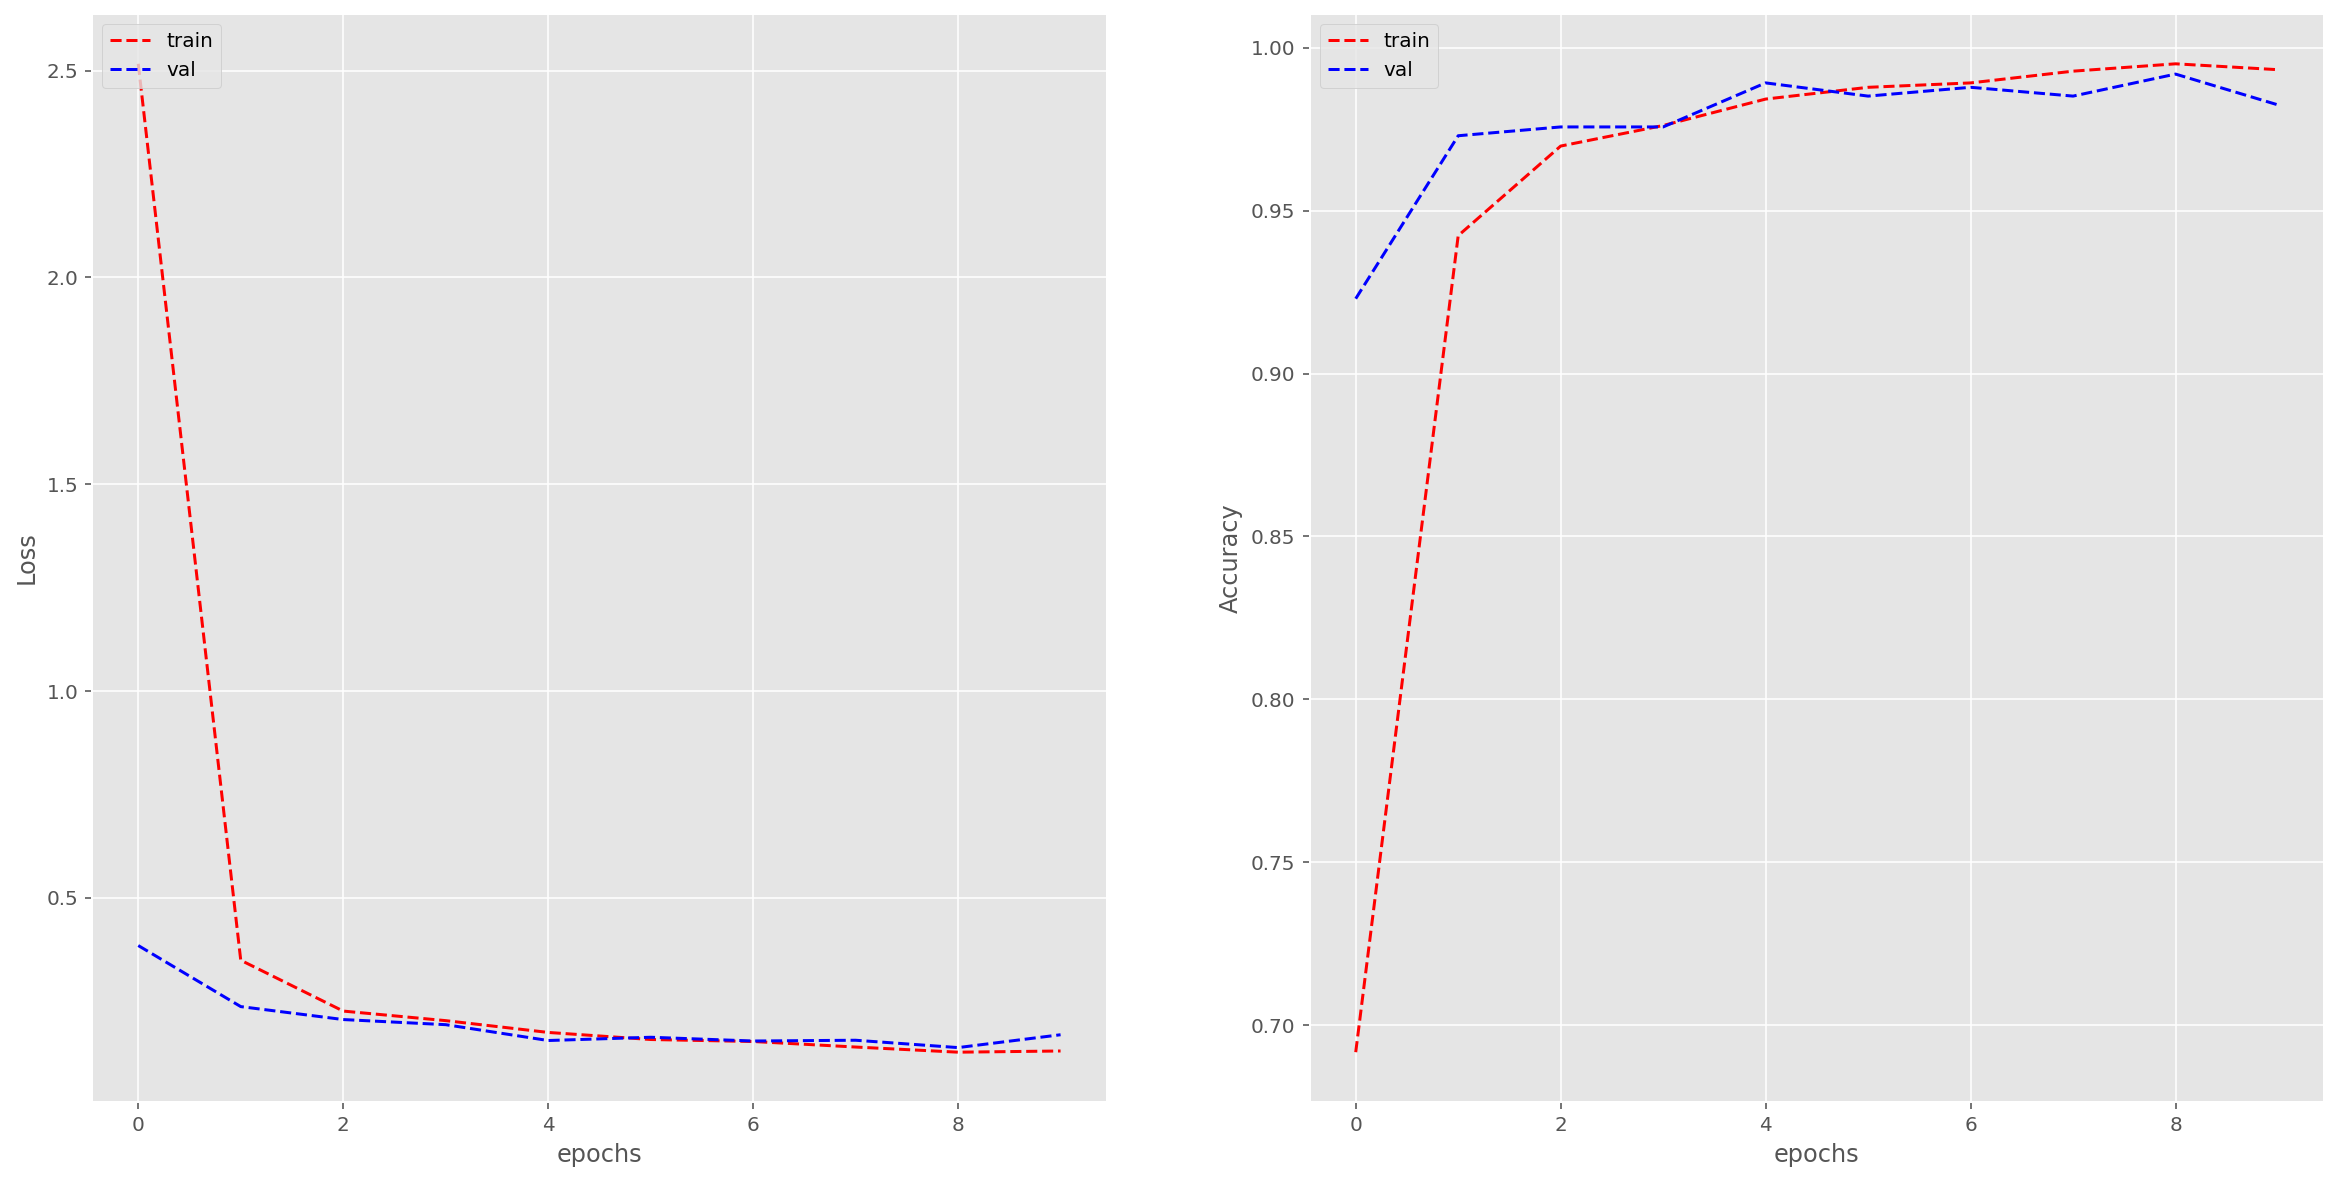

In [29]:
plot_learning_curve(history_Shape_VGG_3.history['loss'], history_Shape_VGG_3.history['val_loss'], 
                    history_Shape_VGG_3.history['categorical_accuracy'], history_Shape_VGG_3.history['val_categorical_accuracy'], 
                    'val', metric_name='Accuracy')

## Saving Appropriate Model<a id='sam'></a>

We'll save the model that is the most appropriate as stated in the report. The base models are saved for later use.

In [30]:
model_Type_VGG_3.save("model_Type_VGG_3")
model_Shape_VGG_1.save("model_Shape_VGG_1")

INFO:tensorflow:Assets written to: model_Type_VGG_3/assets


INFO:tensorflow:Assets written to: model_Type_VGG_3/assets


INFO:tensorflow:Assets written to: model_Shape_VGG_1/assets


INFO:tensorflow:Assets written to: model_Shape_VGG_1/assets


## Using Testing Set <a id='uts'></a>

### Test Set Type <a id='tst'></a>

Lets now load in our model for proper testing to be done.

In [31]:
model_Type = tf.keras.models.load_model("model_Type_VGG_3");
model_Shape = tf.keras.models.load_model("model_Shape_VGG_1");

Setup image generator for types of signs from our test set.

In [32]:
test_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image Paths",
        y_col="Types",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 16 classes.


Lets evaluate our model and see our performance measure.

In [33]:
model_Type.evaluate(test_generator)

24/24 [==============================] - 2s 73ms/step - loss: 0.2545 - categorical_accuracy: 0.9676


[0.25453197956085205, 0.9675675630569458]

Lets now plot a sample of images and see some of the predictions.

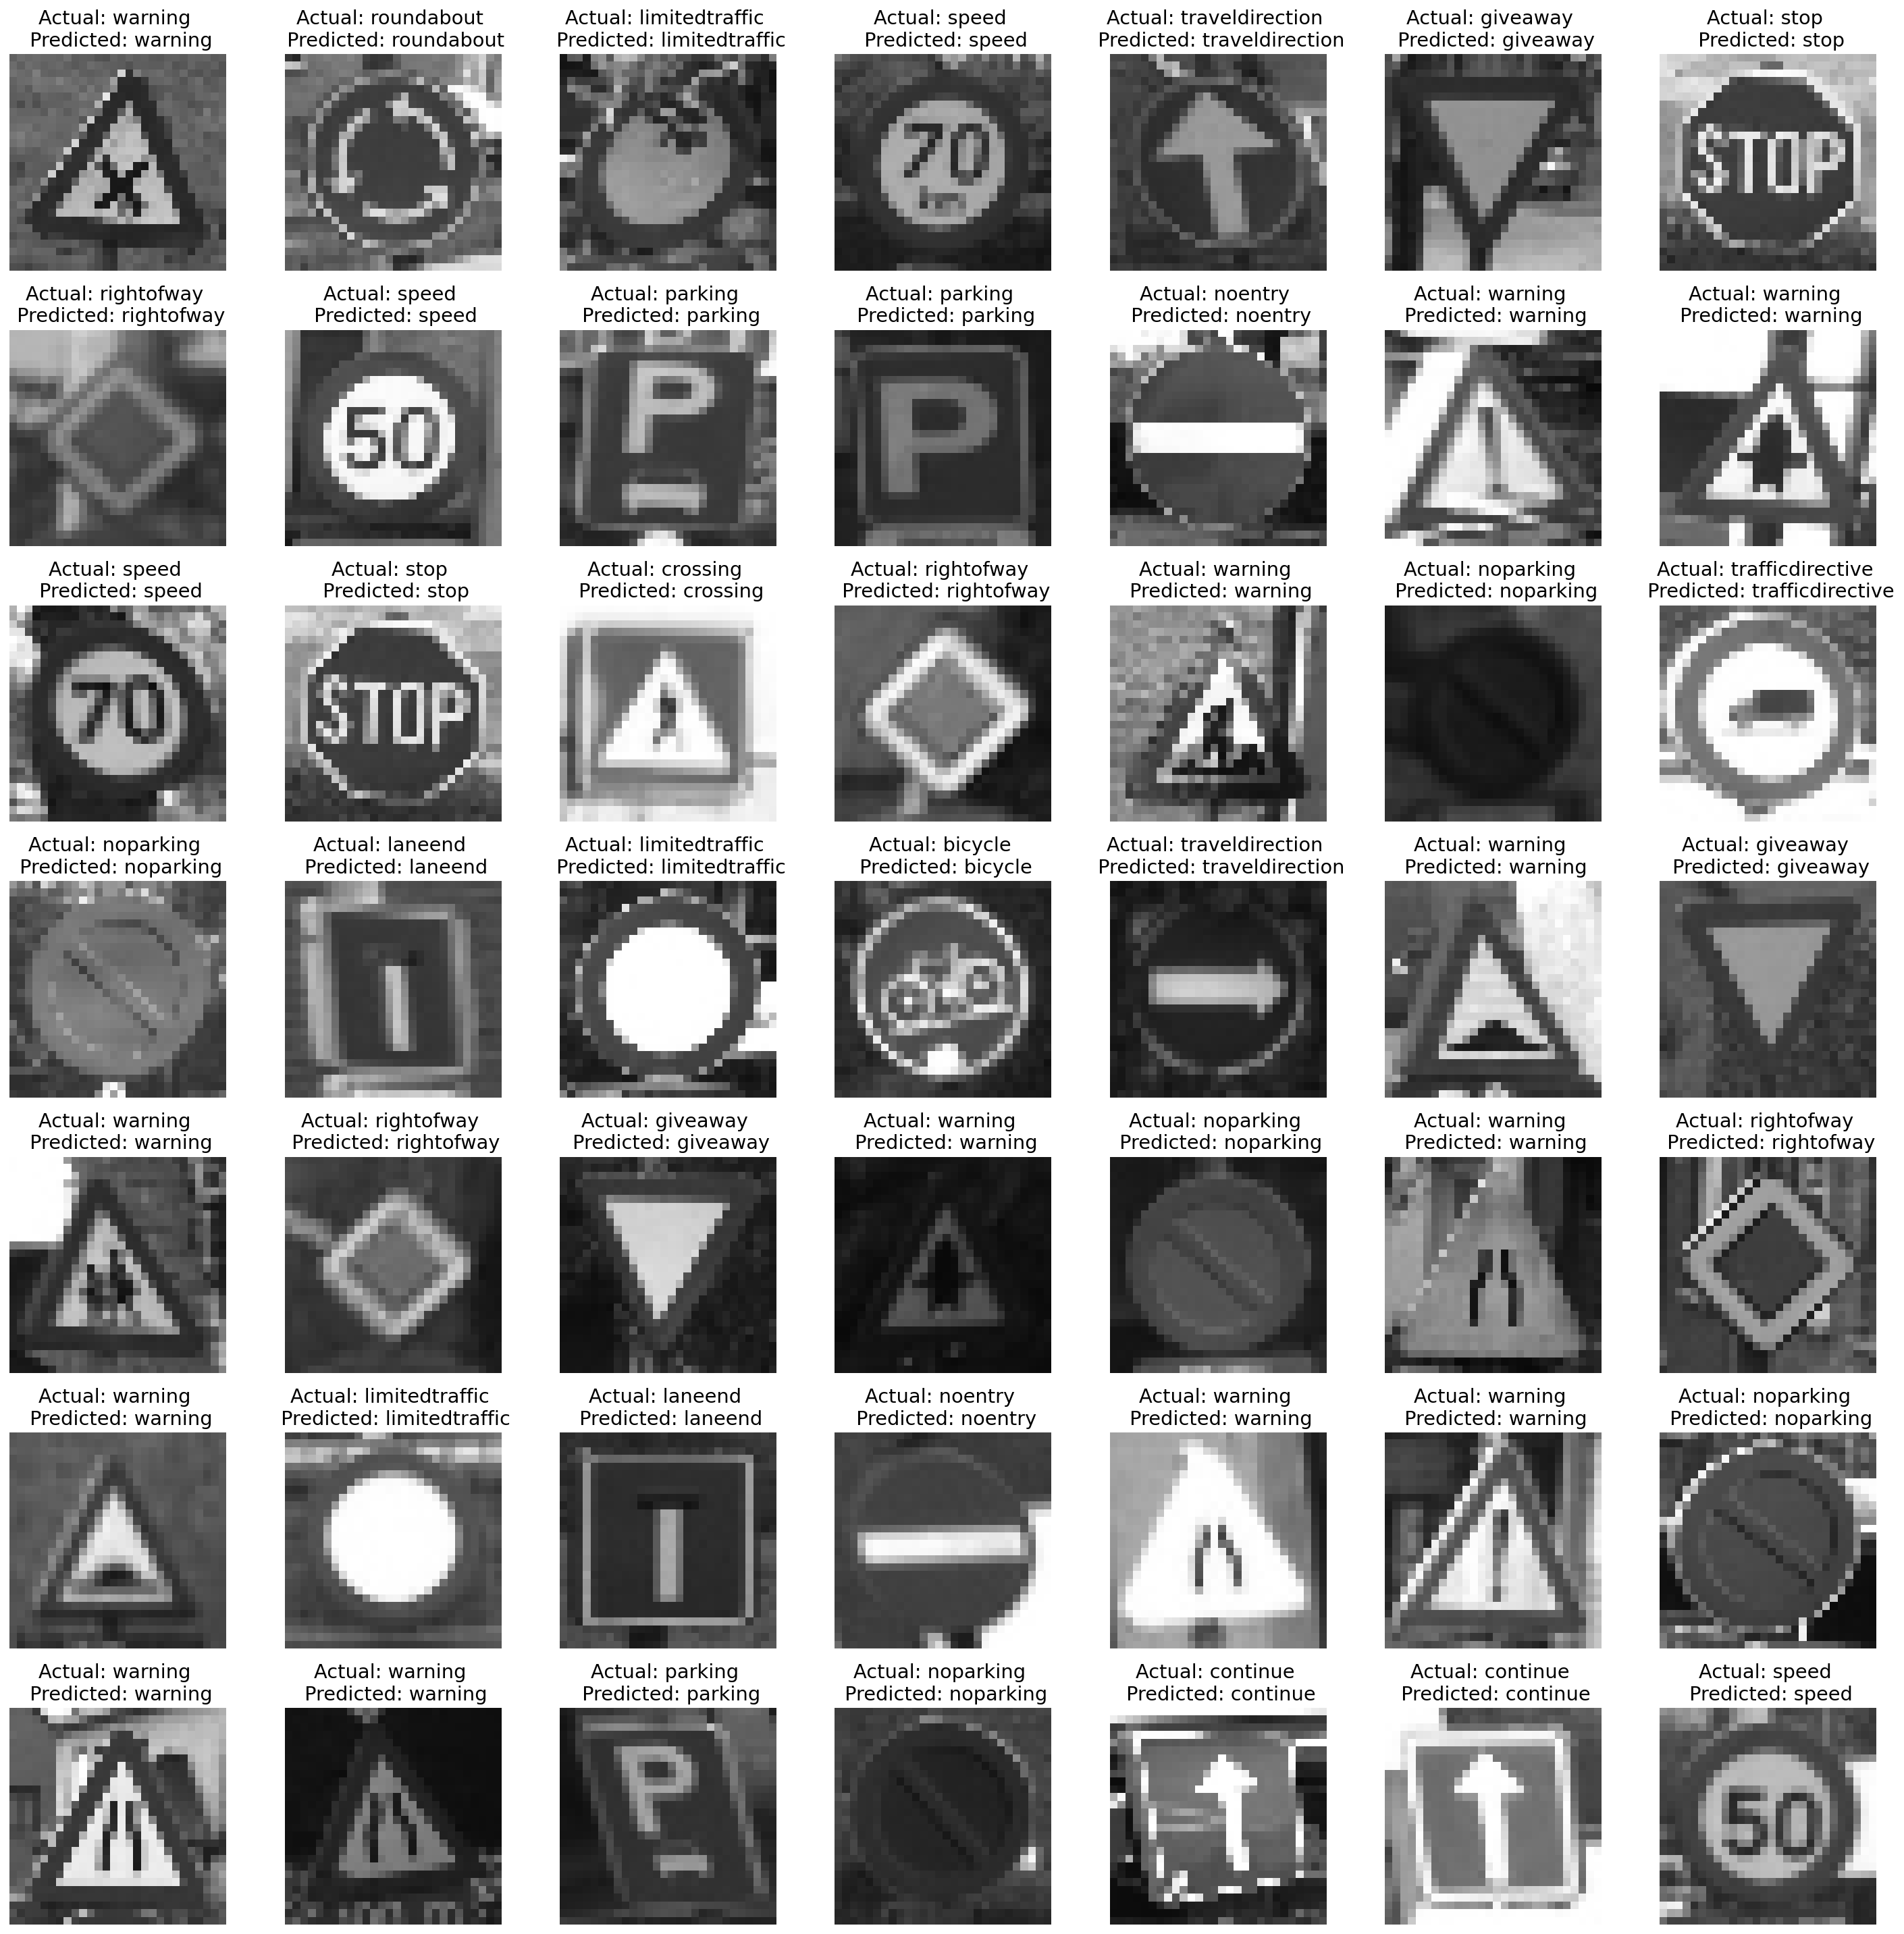

Correct: 49


In [34]:
type_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic','noentry','noparking',
              'roundabout','speed','trafficdirective','traveldirection', 'continue',
              'crossing', 'laneend', 'parking', 'giveaway', 'warning']
type_names.sort()

test_type = 0

plt.figure(figsize=(20,20))
for i in range(49):
    # define subplot
    plt.subplot(7, 7, i+1)

    # generate batch of images
    batch = test_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # prediction of the model
    label_predict = model_Type.predict(image, verbose=0)
    
    # reshape array to proper size
    image = np.squeeze(image)
    
    # labels for images
    label_true = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title("Actual: {} \n Predicted: {}".format(type_names[np.argmax(label_true[0])], type_names[np.argmax(label_predict[0])]))
    plt.axis('off')
    
    if(type_names[np.argmax(label_true[0])] == type_names[np.argmax(label_predict[0])]):
        test_type += 1
        
plt.tight_layout()
plt.show()

print("Correct: {}".format(test_type))

### Test Set Shape <a id='tss'></a>

Setup image generator for shapes of signs from our test set.

In [35]:
test_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image Paths",
        y_col="Shapes",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 5 classes.


Lets evaluate our model and see our performance measure.

In [36]:
model_Shape.evaluate(test_generator)

24/24 [==============================] - 1s 28ms/step - loss: 0.1299 - categorical_accuracy: 0.9865


[0.12991519272327423, 0.9864864945411682]

Lets now load in our model for proper testing to be done.

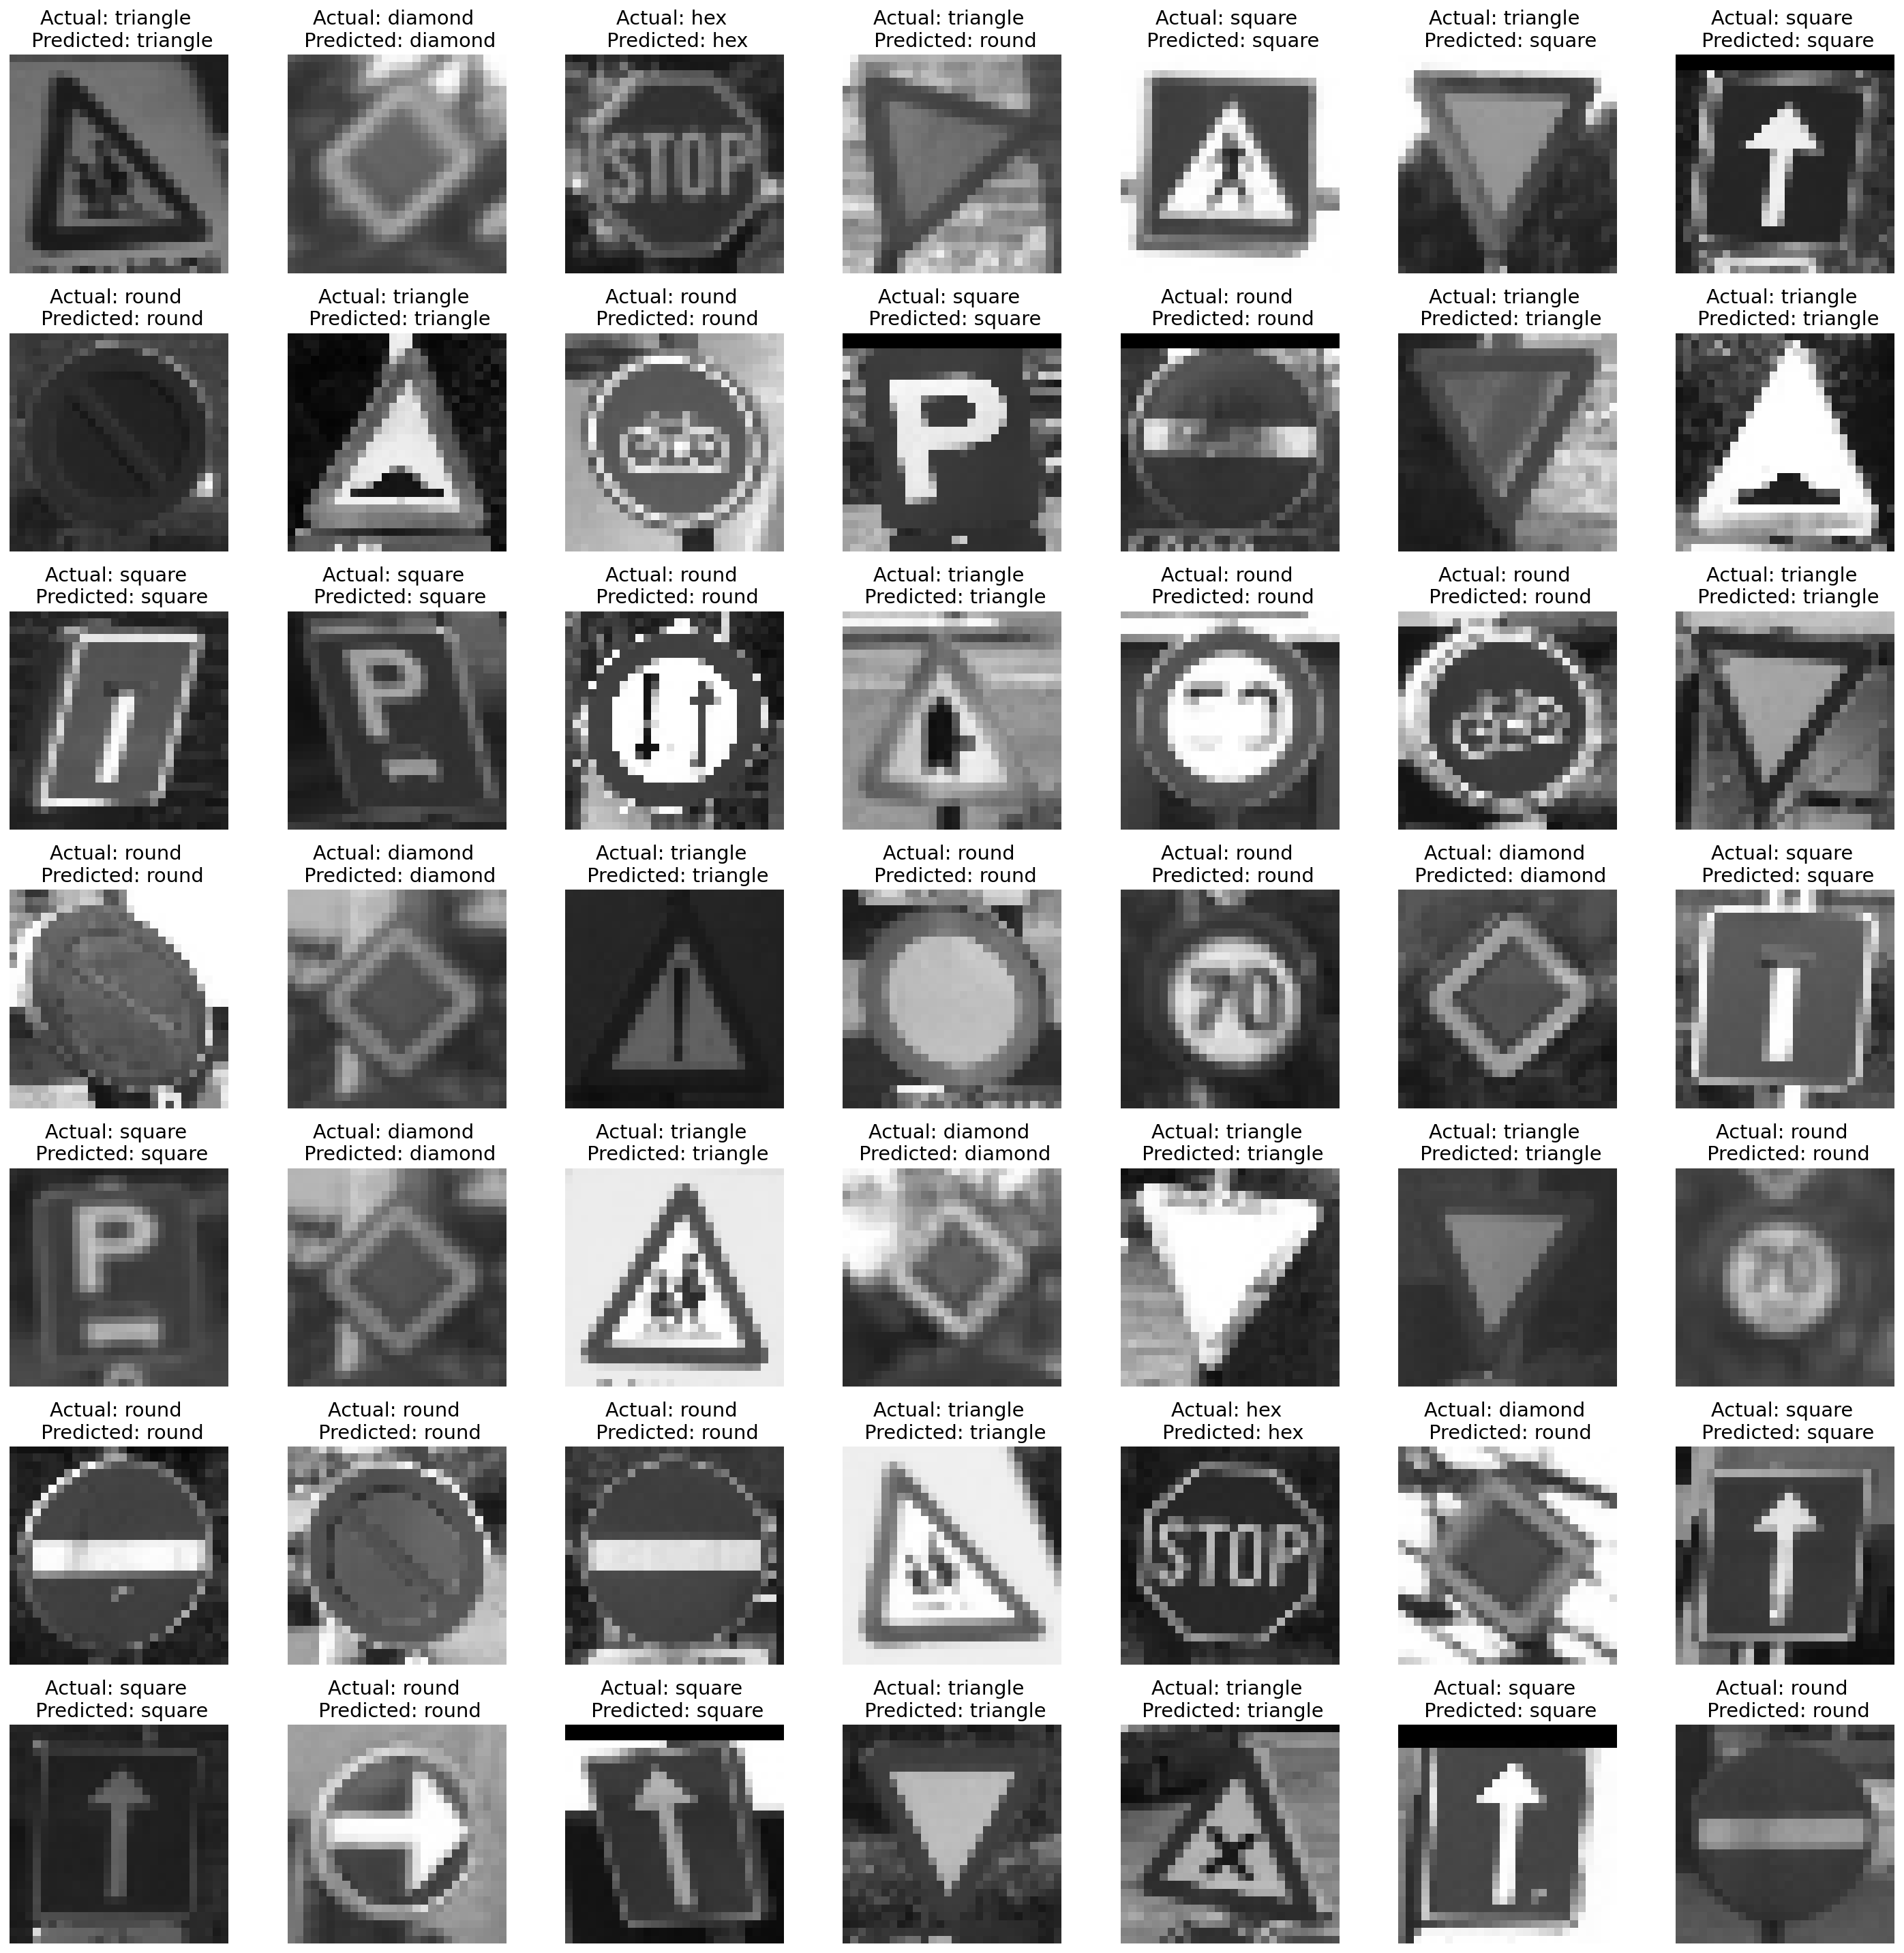

Correct: 46


In [37]:
shape_names = ['diamond','hex','round','square','triangle']
shape_names.sort()

test_shape = 0

plt.figure(figsize=(20,20))
for i in range(49):
    # define subplot
    plt.subplot(7, 7, i+1)

    # generate batch of images
    batch = test_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # prediction of the model
    label_predict = model_Shape.predict(image, verbose=0)
    
    # reshape array to proper size
    image = np.squeeze(image)
    
    # labels for images
    label_true = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title("Actual: {} \n Predicted: {}".format(shape_names[np.argmax(label_true[0])], shape_names[np.argmax(label_predict[0])]))
    plt.axis('off')
    
    if(shape_names[np.argmax(label_true[0])] == shape_names[np.argmax(label_predict[0])]):
        test_shape += 1
    
plt.tight_layout()
plt.show()

print("Correct: {}".format(test_shape))

## Testing on Unseen Data <a id='toud'></a>

Define a function that preprocess the data to match the grayscale our initial dataset.

In [38]:
def preprocess_image(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

Lets load in the unseen data into a dataframe:

In [39]:
path = "./unseen-data"

types = []
shapes = []

imgs = [f for f in listdir(path) if isfile(join(path, f))]

for i in range(len(imgs)):
    splits = imgs[i].split('-')
    types.append(splits[0])
    shapes.append(splits[1])
    imgs[i] = path + '/' + imgs[i]

data = {"Image Paths" : imgs, "Types" : types, "Shapes" : shapes}
unseen_df = pd.DataFrame(data)

A clean look at our unseen dataframe

In [40]:
unseen_df

,Image Paths,Types,Shapes
0,./unseen-data/speed-round-sign.jpeg,speed,round
1,./unseen-data/crossing-square-sign.jpeg,crossing,square
2,./unseen-data/stop-hex-sign.jpeg,stop,hex
3,./unseen-data/bicycle-square-sign.jpeg,bicycle,square
4,./unseen-data/noentry-round-sign1.jpeg,noentry,round
5,./unseen-data/bicycle-square-sign1.jpeg,bicycle,square
6,./unseen-data/speed-round-sign1.jpeg,speed,round
7,./unseen-data/noentry-round-sign.jpeg,noentry,round
8,./unseen-data/stop-hex-sign1.jpeg,stop,hex
9,./unseen-data/rightofway-diamond-sign.jpeg,rightofway,diamond


Lets generate our unseen data for types of signs, inclusive of preprocessing

In [41]:
unseen_datagen = ImageDataGenerator(preprocessing_function=preprocess_image, data_format='channels_last')

batch_size = 1

unseen_type_generator = unseen_datagen.flow_from_dataframe(
        dataframe=unseen_df,
        directory='./',
        x_col="Image Paths",
        y_col="Types",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 10 validated image filenames belonging to 6 classes.


Lets generate our unseen data for shapes of signs, inclusive of preprocessing

In [42]:
batch_size = 1

unseen_shape_generator = unseen_datagen.flow_from_dataframe(
        dataframe=unseen_df,
        directory='./',
        x_col="Image Paths",
        y_col="Shapes",
        target_size = (28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 10 validated image filenames belonging to 4 classes.


Double check type labels are correct for each image

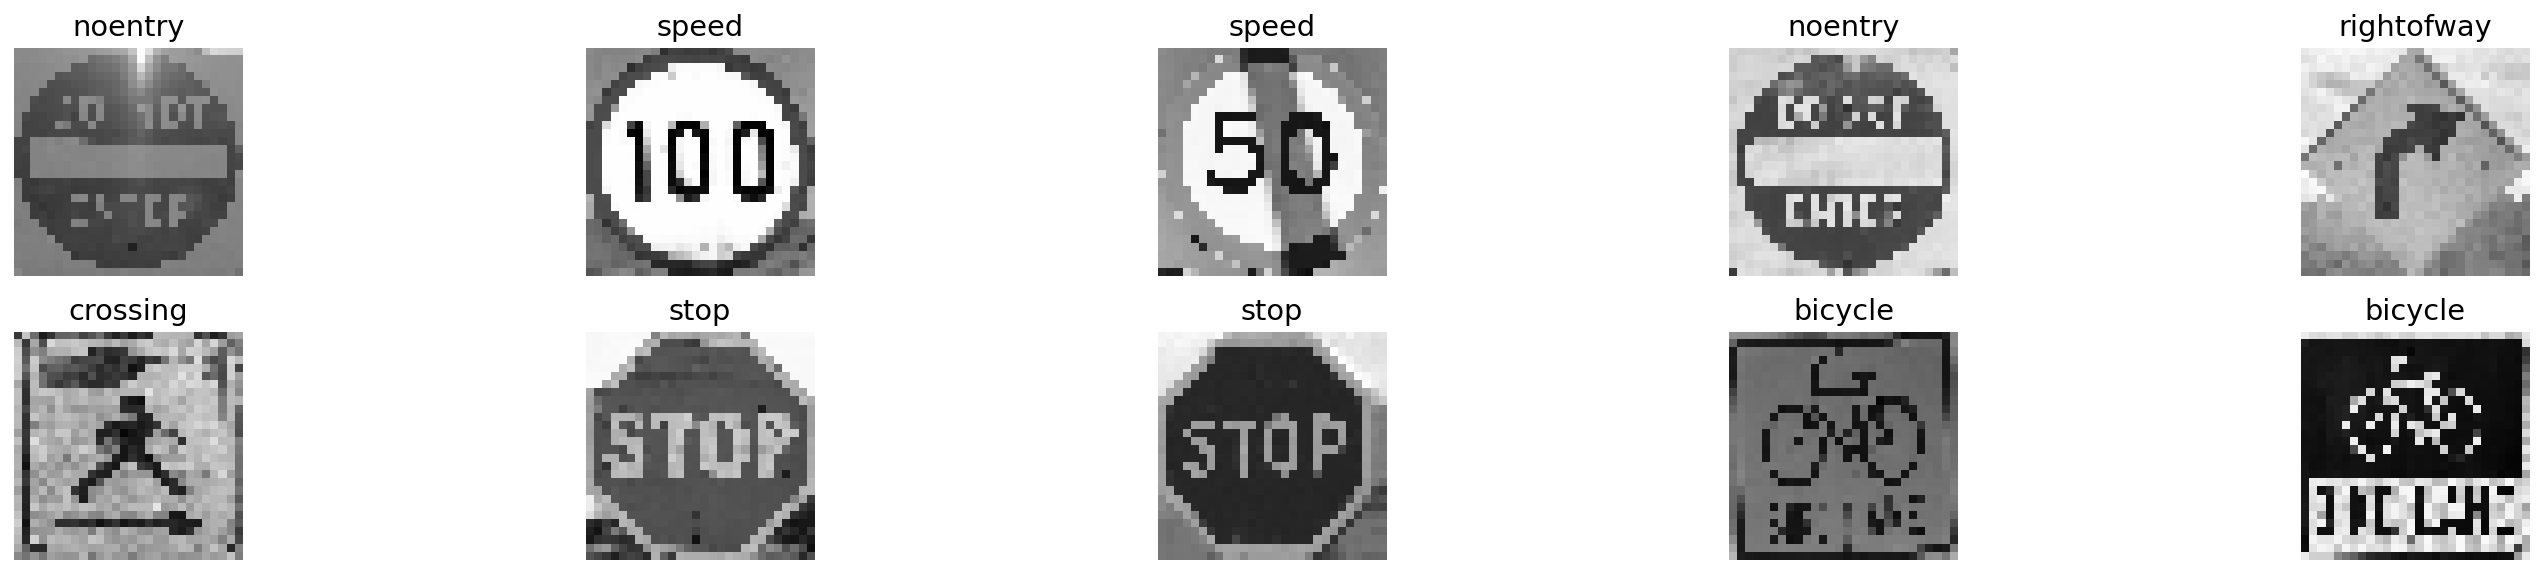

In [43]:
unseen_type_names = ['rightofway', 'stop', 'bicycle', 'noentry', 'speed', 'crossing']
unseen_type_names.sort()
plt.figure(figsize=(20,10))
for i in range(10):
    # define subplot
    plt.subplot(5, 5, i+1)

    # generate batch of images
    batch = unseen_type_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # labels for images
    label = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title(unseen_type_names[np.argmax(label[0])])
    plt.axis('off')
plt.tight_layout()
plt.show()

Double check shape labels are correct for each image

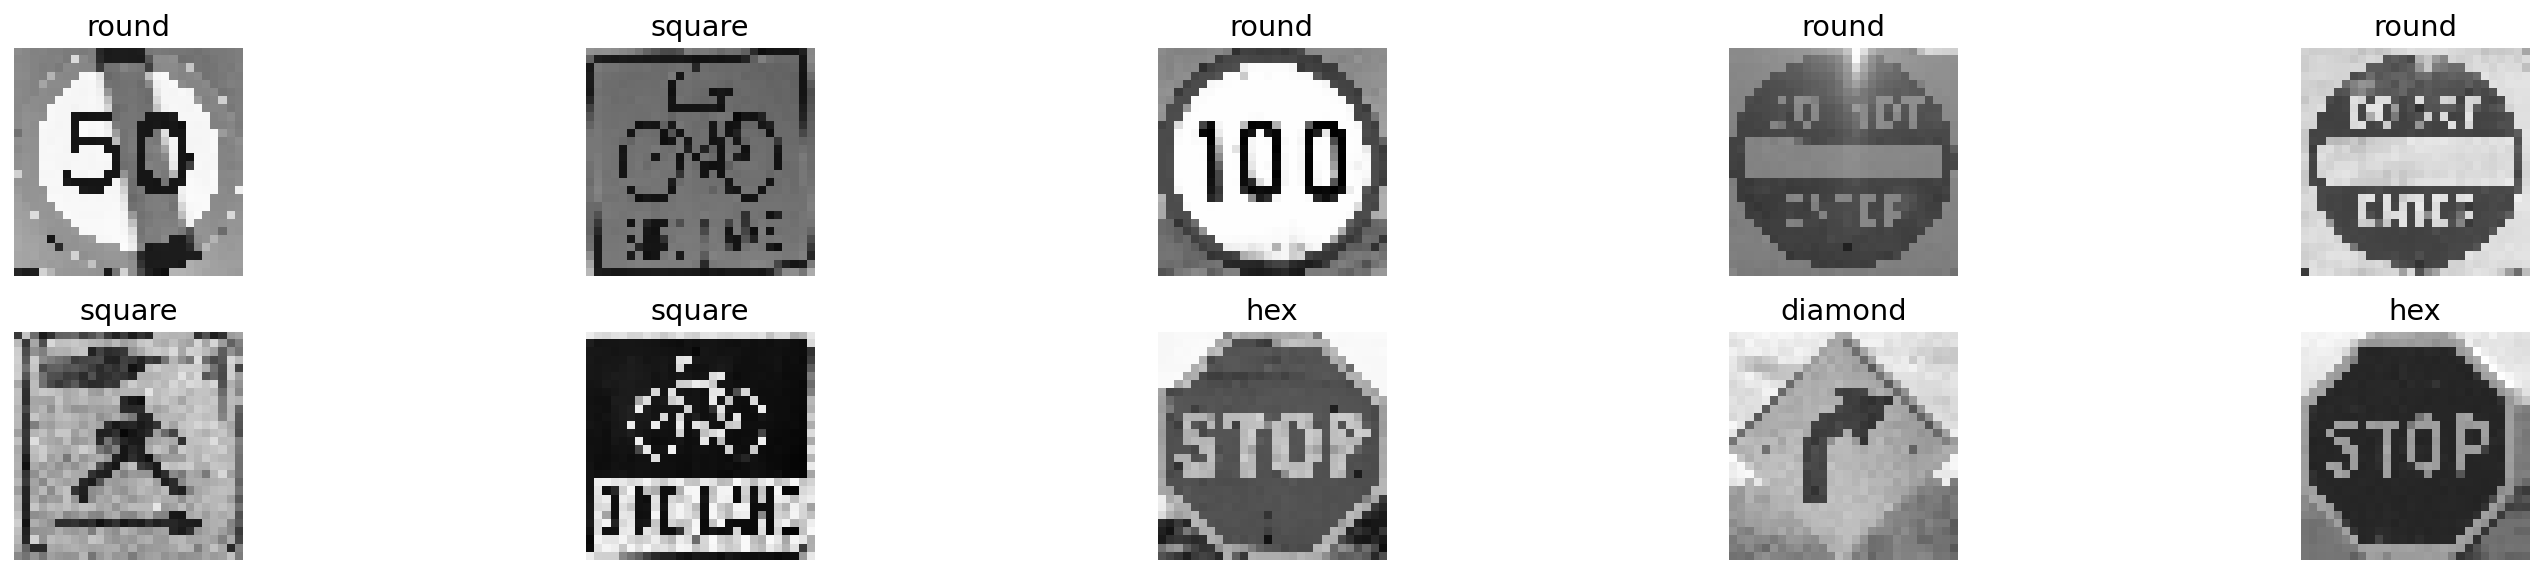

In [44]:
unseen_shape_names = ['round', 'square', 'hex', 'diamond']
unseen_shape_names.sort()

plt.figure(figsize=(20,10))
for i in range(10):
    # define subplot
    plt.subplot(5, 5, i+1)

    # generate batch of images
    batch = unseen_shape_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # labels for images
    label = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title(unseen_shape_names[np.argmax(label[0])])
    plt.axis('off')
plt.tight_layout()
plt.show()

Lets now use our model to predict type of signs on our unseen data.

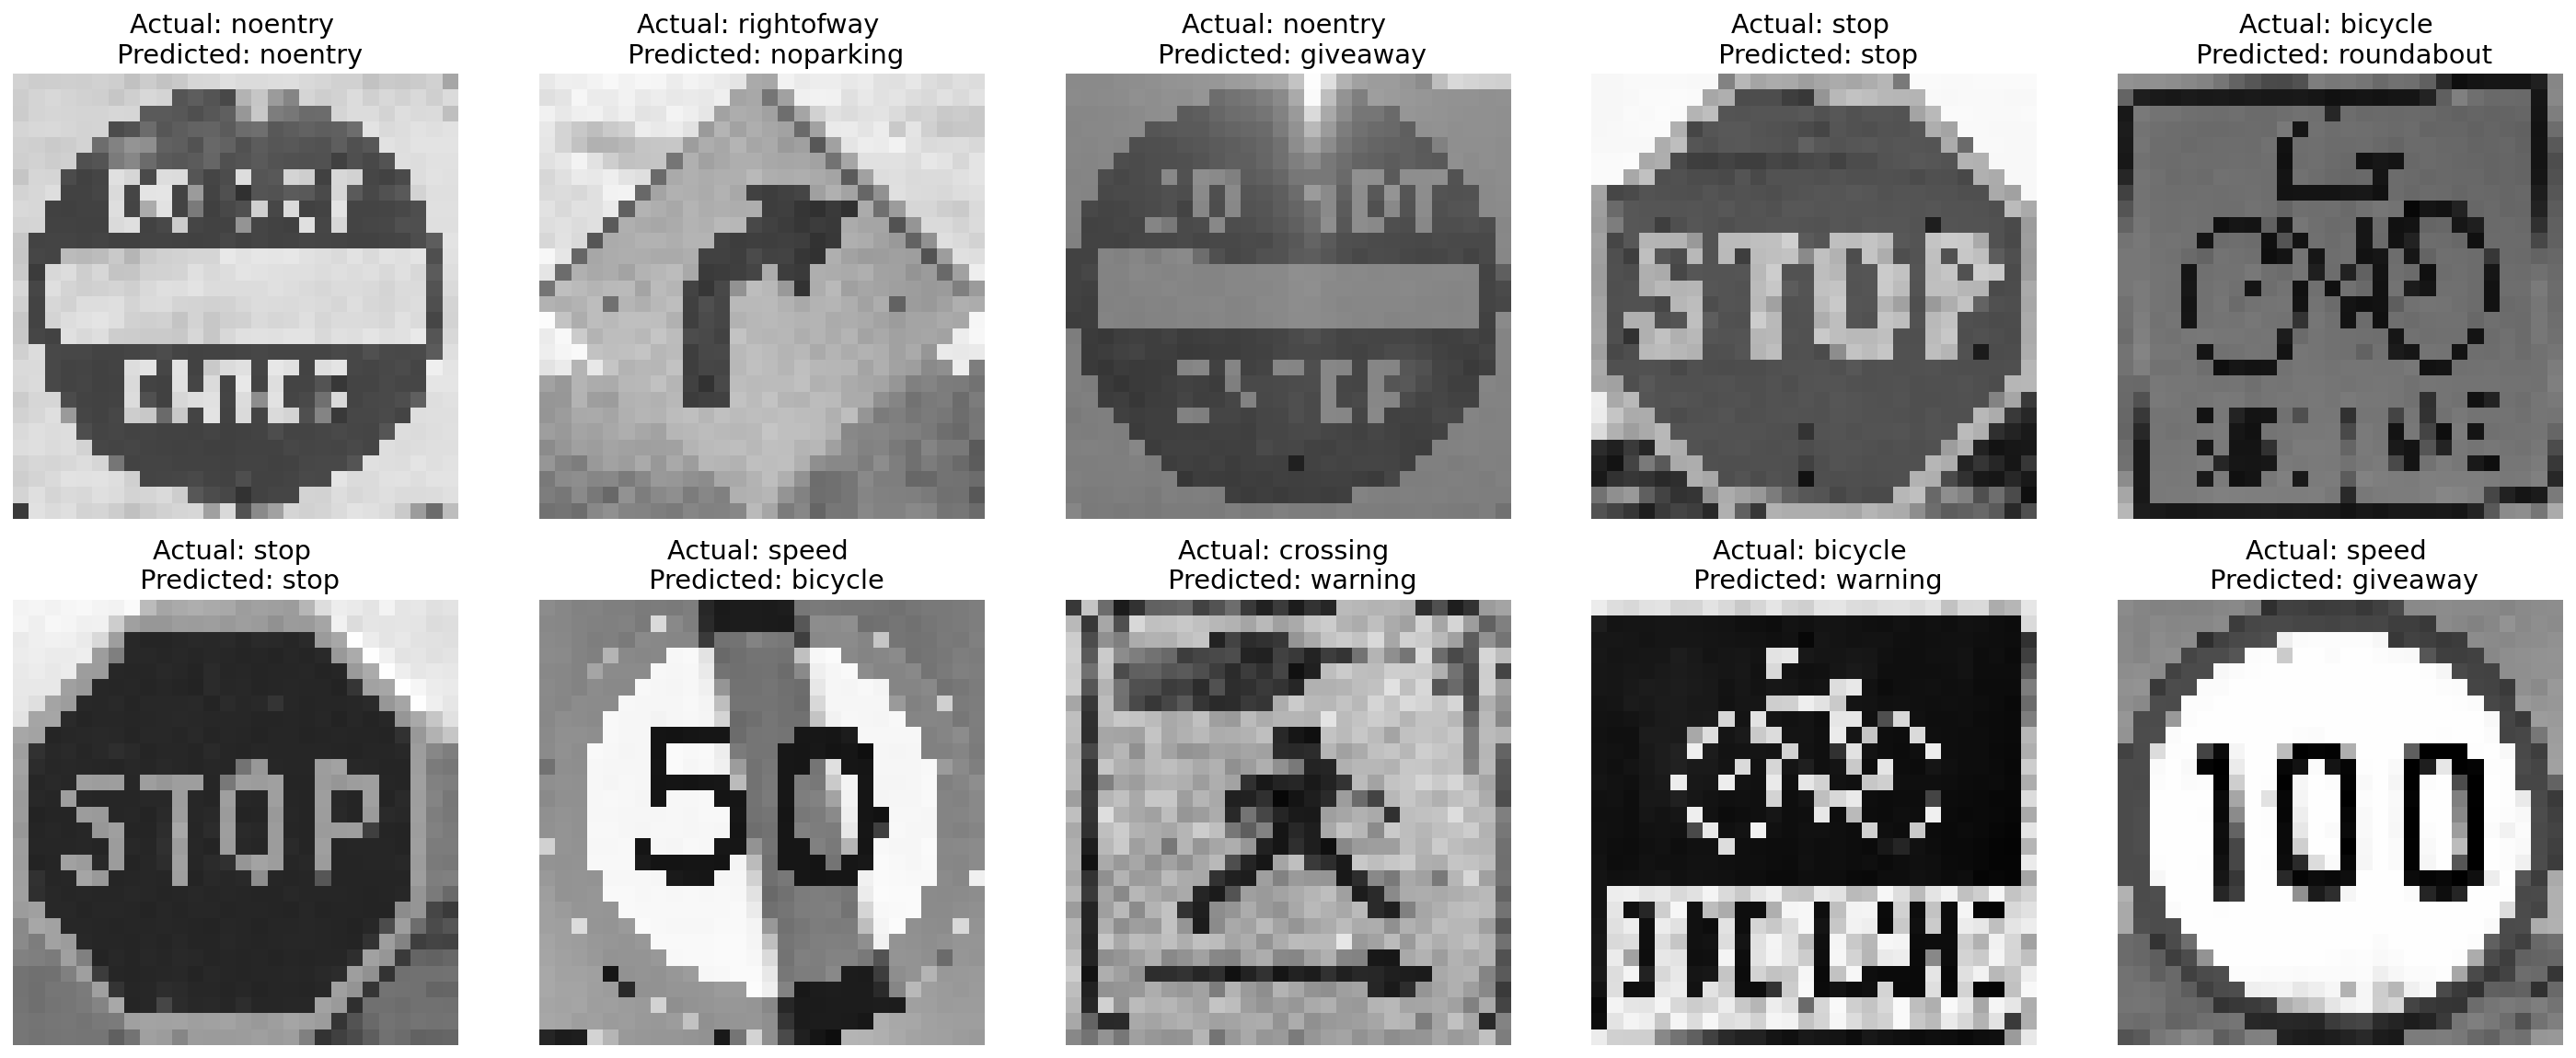

Correct Predictions: 3


In [45]:
type_names = ['rightofway', 'stop', 'bicycle', 'limitedtraffic','noentry','noparking',
              'roundabout','speed','trafficdirective','traveldirection', 'continue',
              'crossing', 'laneend', 'parking', 'giveaway', 'warning']
type_names.sort()
unseen_type_names = ['rightofway', 'stop', 'bicycle', 'noentry', 'speed', 'crossing']
unseen_type_names.sort()

type_correct = 0

plt.figure(figsize=(20,20))
for i in range(10):
    # define subplot
    plt.subplot(5, 5, i+1)

    # generate batch of images
    batch = unseen_type_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # prediction of the model
    label_predict = model_Type.predict(image, verbose=0)
    
    # labels for images
    label_true = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title("Actual: {} \n Predicted: {}".format(unseen_type_names[np.argmax(label_true[0])], type_names[np.argmax(label_predict[0])]))
    plt.axis('off')
    
    if(unseen_type_names[np.argmax(label_true[0])] == type_names[np.argmax(label_predict[0])]):
        type_correct += 1;

plt.tight_layout()
plt.show()

print("Correct Predictions: {}".format(type_correct))

Lets now use our model to predict shape of signs on our unseen data.

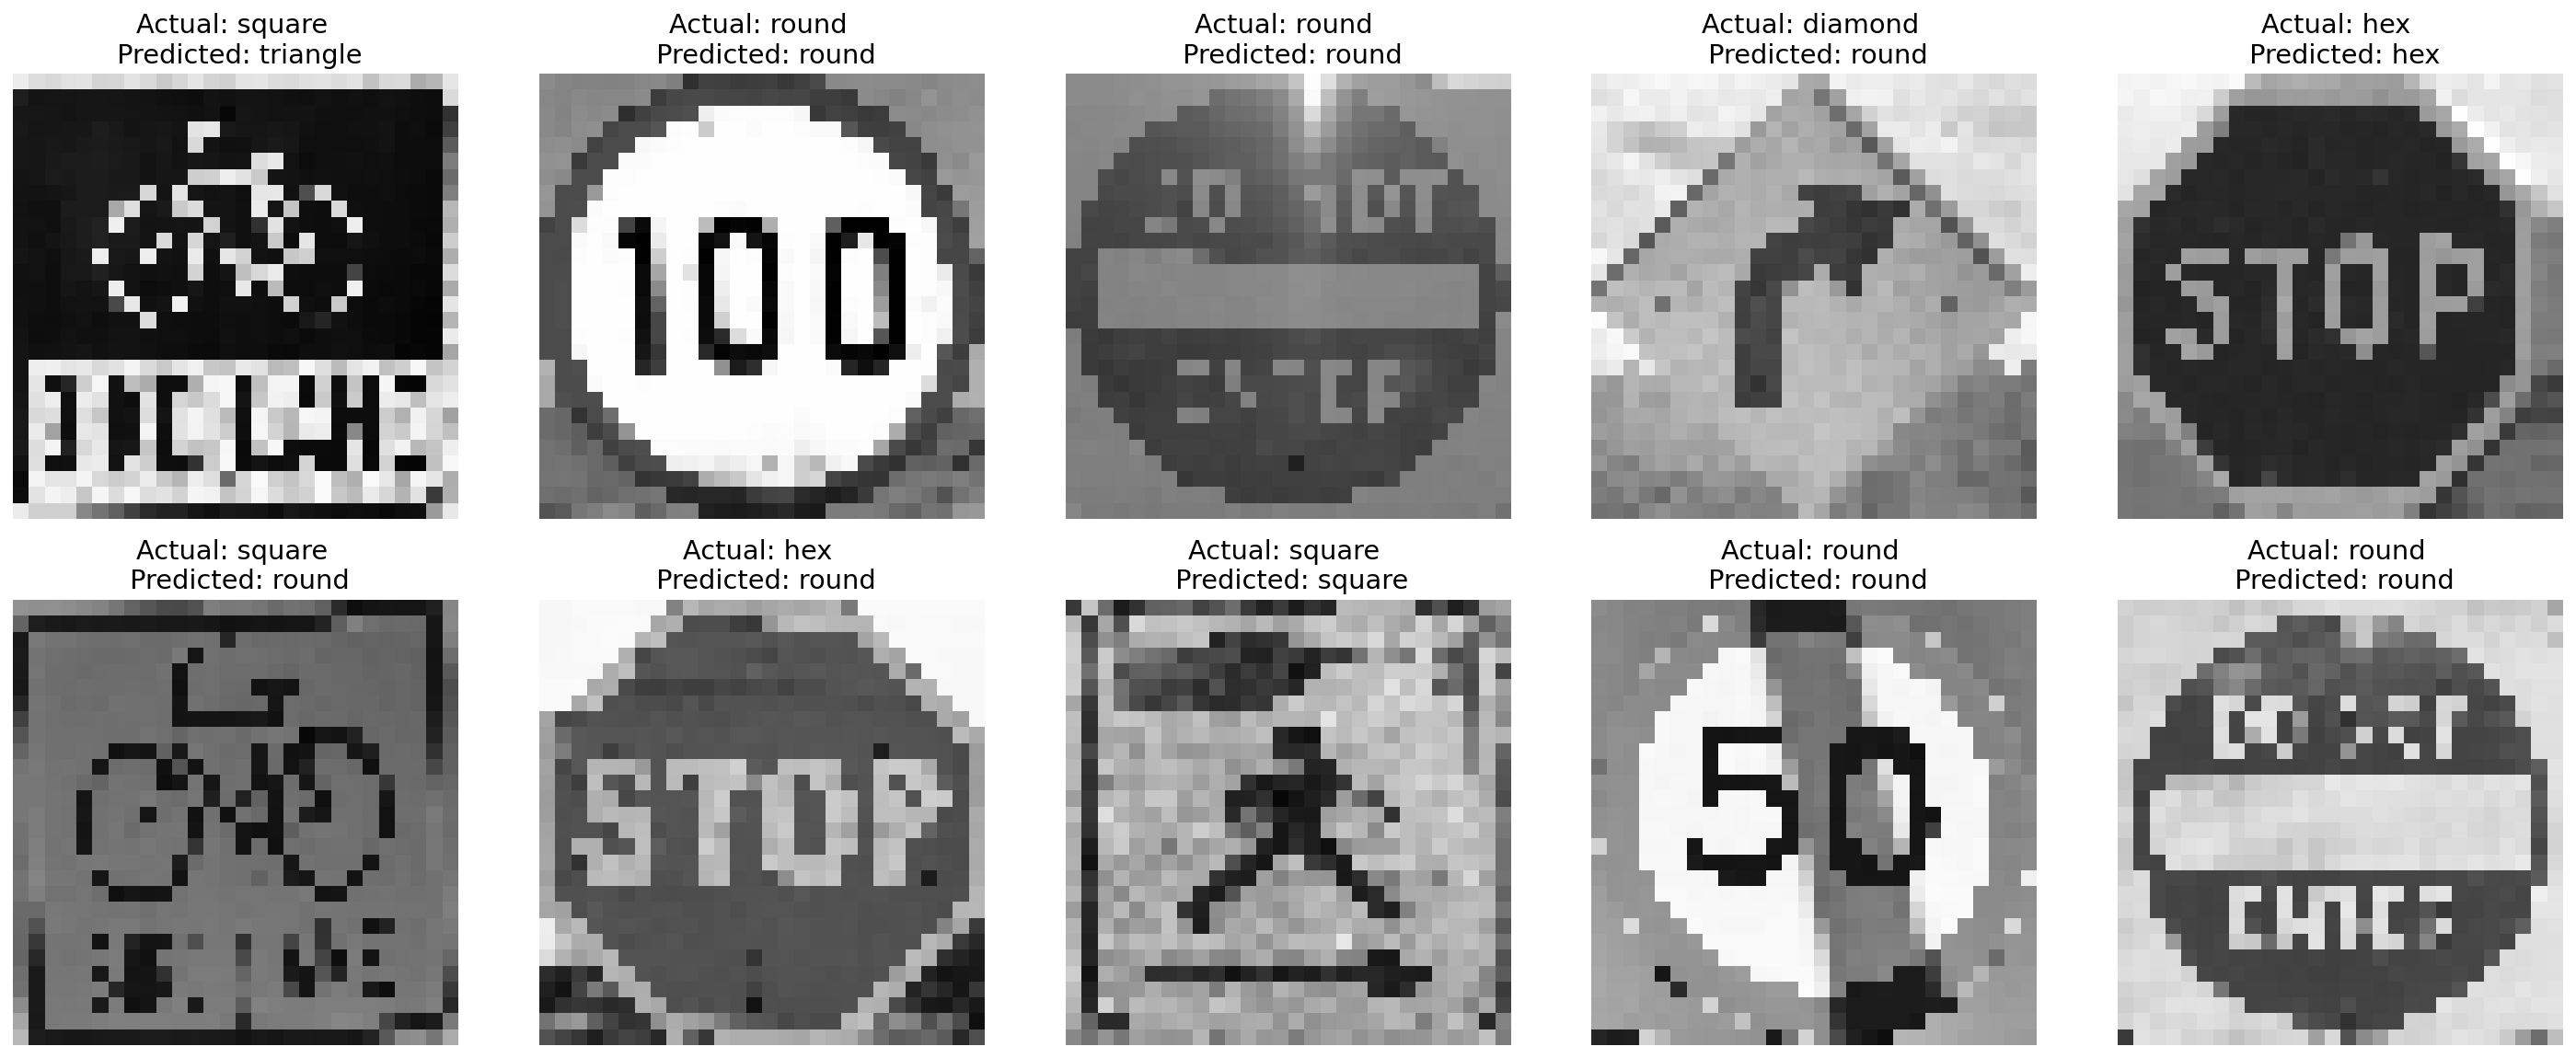

Correct Predictions: 6


In [46]:
shape_names = ['diamond','hex','round','square','triangle']
shape_names.sort()
unseen_shape_names = ['round', 'square', 'hex', 'diamond']
unseen_shape_names.sort()

shape_correct = 0

plt.figure(figsize=(20,20))
for i in range(10):
    # define subplot
    plt.subplot(5, 5, i+1)

    # generate batch of images
    batch = unseen_shape_generator.next()

    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    
    # prediction of the model
    label_predict = model_Shape.predict(image, verbose=0)
    
    # labels for images
    label_true = batch[1]

    # plot raw pixel data
    plt.imshow(image[0])
    plt.title("Actual: {} \n Predicted: {}".format(unseen_shape_names[np.argmax(label_true[0])], shape_names[np.argmax(label_predict[0])]))
    plt.axis('off')
    
    if(unseen_shape_names[np.argmax(label_true[0])] == shape_names[np.argmax(label_predict[0])]):
        shape_correct += 1;
    
plt.tight_layout()
plt.show()

print("Correct Predictions: {}".format(shape_correct))